In [36]:
import json
import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [37]:
# Set output directory
OUTPUT_DIR = "./dataset_analysis"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [38]:
def load_json(file_path):
    """Load JSON file."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except FileNotFoundError:
        print(f"Error: {file_path} not found.")
        return []
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON in {file_path}.")
        return []

In [39]:
def normalize_budget(budget):
    """Normalize budget to numeric value (in thousands)."""
    if not budget:
        return None
    budget = budget.lower().replace('$', '').replace(',', '')
    match = re.match(r'(\d+)(k)?(?:/month|per month|mo)?', budget)
    if match:
        value = int(match.group(1))
        if match.group(2):  # 'k' present
            return value
        return value / 1000  # Convert to thousands
    return None

In [40]:
def normalize_space_size(space):
    """Normalize space size to numeric value (in sqft)."""
    if not space:
        return None
    space = space.lower().replace(',', '').replace('sq ft', 'sqft').replace('square feet', 'sqft')
    match = re.match(r'(\d+)(?:\s*sqft|s\.f\.)', space)
    if match:
        return int(match.group(1))
    return None

In [41]:

def extract_entities(chain, debug=False):
    """Extract all entities from a chain's tenant_profile, including nested fields."""
    profile = chain.get("tenant_profile", {})
    property_prefs = profile.get("Property Preferences", {})
    company_details = profile.get("Company Details", {})
    tenant_rep = profile.get("Tenant Representative Details", {})
    moving_timing = property_prefs.get("Moving Timing", {})

    # Extract lists as concatenated strings
    preferred_neighborhood = ", ".join(property_prefs.get("Preferred Neighborhood", [])) if isinstance(property_prefs.get("Preferred Neighborhood"), list) else property_prefs.get("Preferred Neighborhood", "")
    must_haves = ", ".join(property_prefs.get("Must-Haves", [])) if property_prefs.get("Must-Haves") else ""
    nice_to_haves = ", ".join(property_prefs.get("Nice-to-Haves", [])) if property_prefs.get("Nice-to-Haves") else ""
    pain_points = ", ".join(profile.get("Pain Points", [])) if profile.get("Pain Points") else ""

    # Debug: Print tenant_profile structure for first few chains
    if debug:
        print(f"Debug: tenant_profile keys: {list(profile.keys())}")
        print(f"Debug: Property Preferences keys: {list(property_prefs.keys())}")
        print(f"Debug: Company Details keys: {list(company_details.keys())}")
        print(f"Debug: Tenant Representative Details keys: {list(tenant_rep.keys())}")
        print(f"Debug: Moving Timing keys: {list(moving_timing.keys())}")

    return {
        # Tenant Representative Details
        "First Name": tenant_rep.get("First Name", ""),
        "Last Name": tenant_rep.get("Last Name", ""),
        "Email": tenant_rep.get("Email", ""),
        "Phone": tenant_rep.get("Phone", ""),
        # Company Details
        "Company Name": company_details.get("Company Name", ""),
        "Industry": company_details.get("Industry", ""),
        "Company Size": company_details.get("Company Size", ""),
        "Growth Stage": company_details.get("Growth Stage", ""),
        "Current Neighborhood": company_details.get("Current Neighborhood", ""),
        # Top-level fields
        "First Interaction": profile.get("First Interaction", ""),
        "Last Interaction": profile.get("Last Interaction", ""),
        "Decision-Maker Role": profile.get("Decision-Maker Role", ""),
        # Property Preferences
        "Property Type": property_prefs.get("Property Type", ""),
        "Preferred Neighborhood": preferred_neighborhood,
        "Estimated or Stated Budget": property_prefs.get("Estimated or Stated Budget", ""),
        "Must-Haves": must_haves,
        "Nice-to-Haves": nice_to_haves,
        "Space Size": property_prefs.get("Space Size", ""),
        "Preferred Lease Term": property_prefs.get("Preferred Lease Term", ""),
        "Moving Term": property_prefs.get("Moving Term", ""),
        # Moving Timing
        "min_months": moving_timing.get("min_months", None),
        "max_months": moving_timing.get("max_months", None),
        # Other top-level fields
        "Moving Timeline": profile.get("Moving Timeline", ""),
        "Pain Points": pain_points,
        "Urgency Score": profile.get("Urgency Score", ""),
        "Outcome": profile.get("Outcome", ""),
        "Tenant Personality": profile.get("Tenant Personality", "")
    }

In [42]:
def analyze_dataset(data):
    """Analyze dataset diversity and return statistics."""
    stats = {
        "num_chains": len(data),
        "entities": {
            "First Name": [],
            "Last Name": [],
            "Email": [],
            "Phone": [],
            "Company Name": [],
            "Industry": [],
            "Company Size": [],
            "Growth Stage": [],
            "Current Neighborhood": [],
            "First Interaction": [],
            "Last Interaction": [],
            "Decision-Maker Role": [],
            "Property Type": [],
            "Preferred Neighborhood": [],
            "Estimated or Stated Budget": {"raw": [], "normalized": []},
            "Must-Haves": [],
            "Nice-to-Haves": [],
            "Space Size": {"raw": [], "normalized": []},
            "Preferred Lease Term": [],
            "Moving Term": [],
            "min_months": [],
            "max_months": [],
            "Moving Timeline": [],
            "Pain Points": [],
            "Urgency Score": [],
            "Outcome": [],
            "Tenant Personality": []
        },
        "email_chain_lengths": []
    }

    for idx, chain in enumerate(data):
        # Extract entities with debugging for first 5 chains
        entities = extract_entities(chain, debug=idx < 5)
        for key in entities:
            if key in ["Estimated or Stated Budget", "Space Size"]:
                stats["entities"][key]["raw"].append(entities[key])
                # Normalize Budget and SpaceSize
                if key == "Estimated or Stated Budget":
                    norm_value = normalize_budget(entities[key])
                else:  # Space Size
                    norm_value = normalize_space_size(entities[key])
                stats["entities"][key]["normalized"].append(norm_value)
            else:
                stats["entities"][key].append(entities[key])

        # Email chain length
        email_chain = chain.get("email_chain", [])
        stats["email_chain_lengths"].append(len(email_chain))

    # Compute distributions and summaries
    results = {
        "num_chains": stats["num_chains"],
        "entity_distributions": {},
        "email_chain_length": {
            "mean": np.mean(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "std": np.std(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "min": min(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "max": max(stats["email_chain_lengths"]) if stats["email_chain_lengths"] else 0,
            "distribution": dict(Counter(stats["email_chain_lengths"]))
        }
    }

    # Analyze each entity
    for entity, values in stats["entities"].items():
        if entity in ["Estimated or Stated Budget", "Space Size"]:
            raw_counts = Counter(values["raw"])
            norm_values = [v for v in values["normalized"] if v is not None]
            results["entity_distributions"][entity] = {
                "raw_counts": dict(raw_counts),
                "unique_raw": len(raw_counts),
                "normalized": norm_values,
                "normalized_mean": np.mean(norm_values) if norm_values else 0,
                "normalized_std": np.std(norm_values) if norm_values else 0,
                "normalized_min": min(norm_values) if norm_values else 0,
                "normalized_max": max(norm_values) if norm_values else 0,
                "missing": sum(1 for v in values["raw"] if not v)
            }
        else:
            counts = Counter(values)
            results["entity_distributions"][entity] = {
                "counts": dict(counts),
                "unique": len(counts),
                "missing": sum(1 for v in values if not v)
            }

    return results

In [43]:
def visualize_distributions(results):
    """Visualize entity distributions and save plots."""
    numerical_fields = {
        "Estimated or Stated Budget": "Budget ($k)",
        "Space Size": "Space Size (sqft)",
        "min_months": "Min Moving Timing (months)",
        "max_months": "Max Moving Timing (months)",
        "Urgency Score": "Urgency Score"
    }

    categorical_fields = [
        "First Name", "Last Name", "Email", "Phone", "Company Name", "Industry",
        "Company Size", "Growth Stage", "Current Neighborhood", "First Interaction",
        "Last Interaction", "Decision-Maker Role", "Property Type", "Preferred Neighborhood",
        "Must-Haves", "Nice-to-Haves", "Preferred Lease Term", "Moving Term",
        "Moving Timeline", "Pain Points", "Outcome", "Tenant Personality"
    ]

    # Visualize numerical fields
    for field, label in numerical_fields.items():
        if field in ["Estimated or Stated Budget", "Space Size"]:
            values = [v for v in results["entity_distributions"][field]["normalized"] if v is not None]
        else:
            values = [v for v in results["entity_distributions"][field]["counts"].keys() if isinstance(v, (int, float)) and v is not None]
        if values:
            plt.figure(figsize=(10, 6))
            sns.histplot(values, bins=20, kde=True)
            plt.title(f"Distribution of {label}")
            plt.xlabel(label)
            plt.ylabel("Count")
            plt.show()
        else:
            print(f"Warning: No valid {field} data for visualization")

    # Visualize categorical fields
    for field in categorical_fields:
        # The line below has been changed to access the correct key 'counts'
        counts = results["entity_distributions"][field]["counts"]
        if counts and any(k for k in counts if k):
            plt.figure(figsize=(12, 8))
            pd.Series(counts).sort_values(ascending=False).head(20).plot(kind='bar')  # Limit to top 20 for readability
            plt.title(f"Distribution of {field}")
            plt.xlabel(field)
            plt.ylabel("Count")
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
        else:
            print(f"Warning: No valid {field} data for visualization")

    # Email chain length
    chain_lengths = results["email_chain_length"]["distribution"]
    if chain_lengths:
        plt.figure(figsize=(10, 6))
        pd.Series(chain_lengths).sort_index().plot(kind='bar')
        plt.title("Distribution of Email Chain_lengths")
        plt.xlabel("Number of Emails")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

In [44]:
# Load data
data = load_json("synthetic_email_data.json")

# Analyze dataset
results = analyze_dataset(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "analysis_results.json"), "w") as f:
    json.dump(results, f, indent=2)

Debug: tenant_profile keys: ['Tenant Representative Details', 'Company Details', 'First Interaction', 'Last Interaction', 'Decision-Maker Role', 'Property Preferences', 'Moving Timeline', 'Pain Points', 'Urgency Score', 'Outcome', 'Tenant Personality']
Debug: Property Preferences keys: ['Property Type', 'Preferred Neighborhood', 'Estimated or Stated Budget', 'Must-Haves', 'Nice-to-Haves', 'Space Size', 'Preferred Lease Term']
Debug: Company Details keys: ['Company Name', 'Industry', 'Company Size', 'Growth Stage', 'Current Neighborhood']
Debug: Tenant Representative Details keys: ['First Name', 'Last Name', 'Email', 'Phone']
Debug: Moving Timing keys: []
Debug: tenant_profile keys: ['Tenant Representative Details', 'Company Details', 'First Interaction', 'Last Interaction', 'Decision-Maker Role', 'Property Preferences', 'Moving Timeline', 'Pain Points', 'Urgency Score', 'Outcome', 'Tenant Personality']
Debug: Property Preferences keys: ['Property Type', 'Preferred Neighborhood', 'Estim

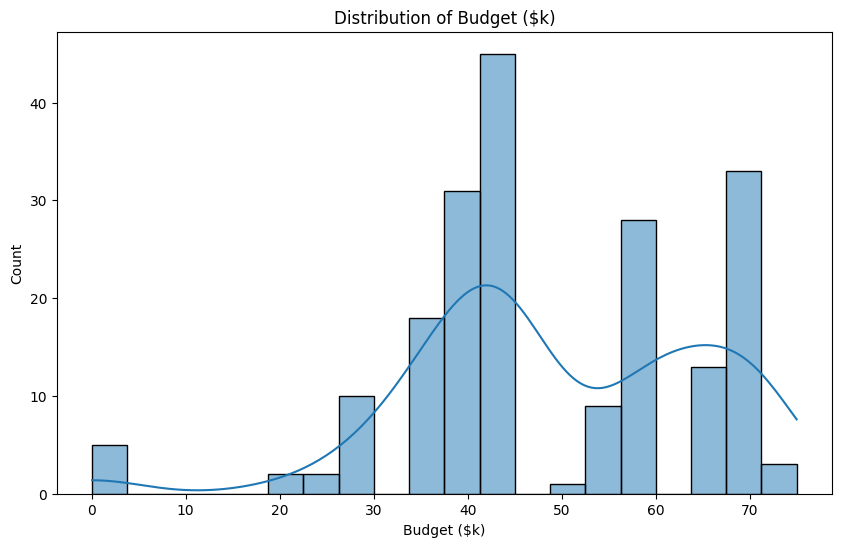

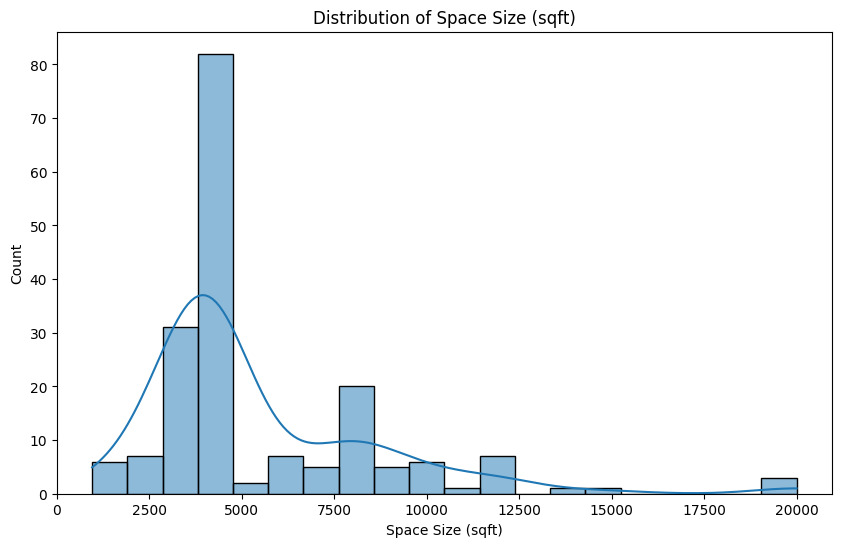

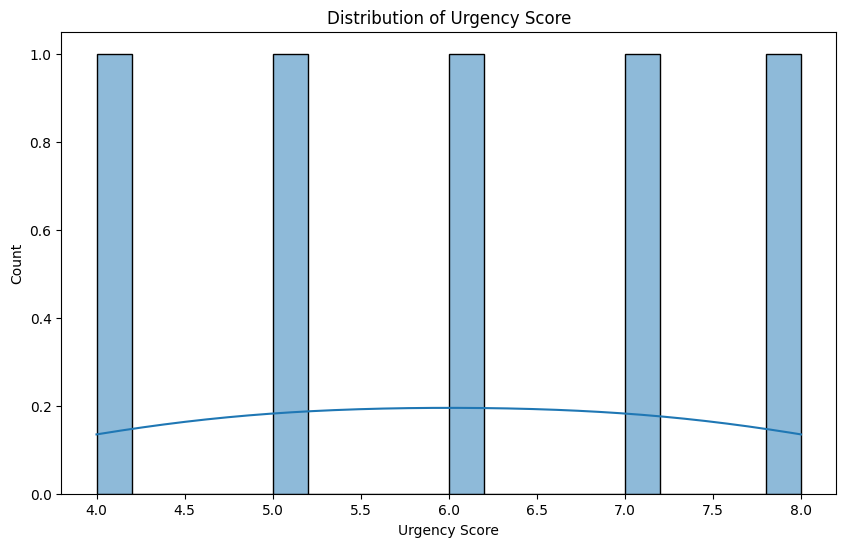

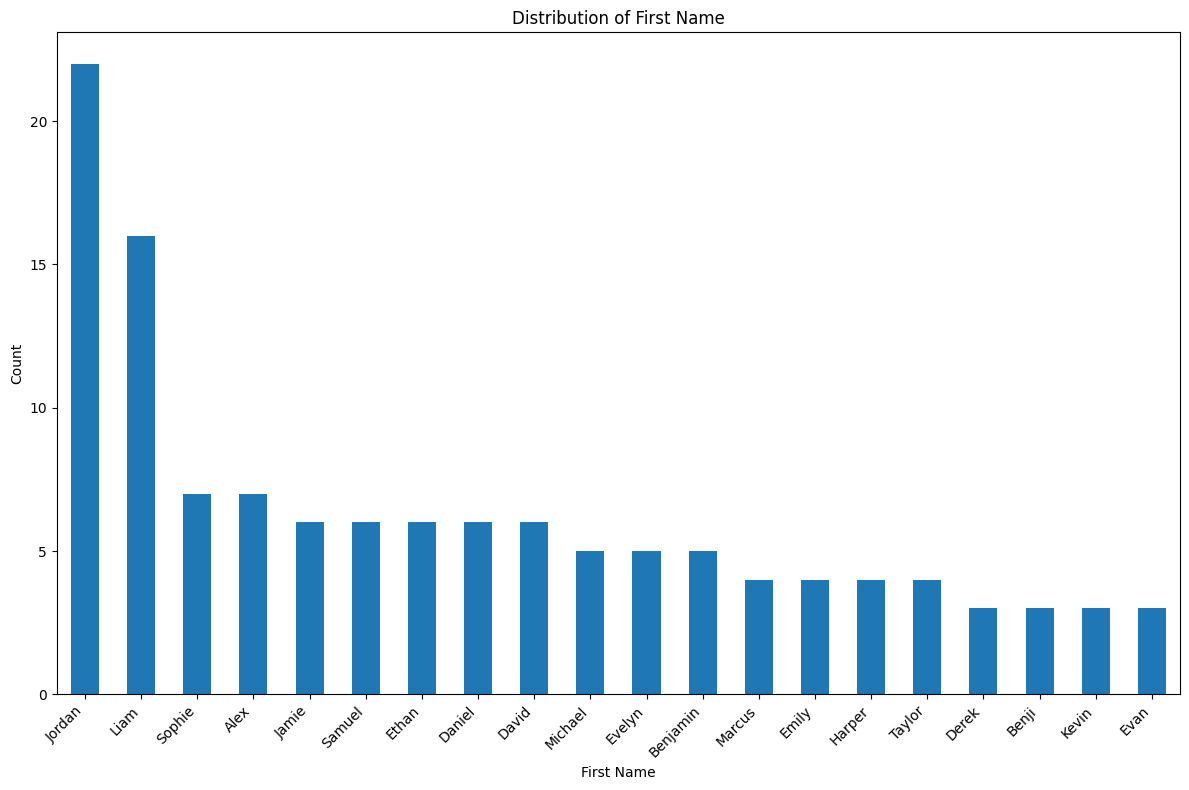

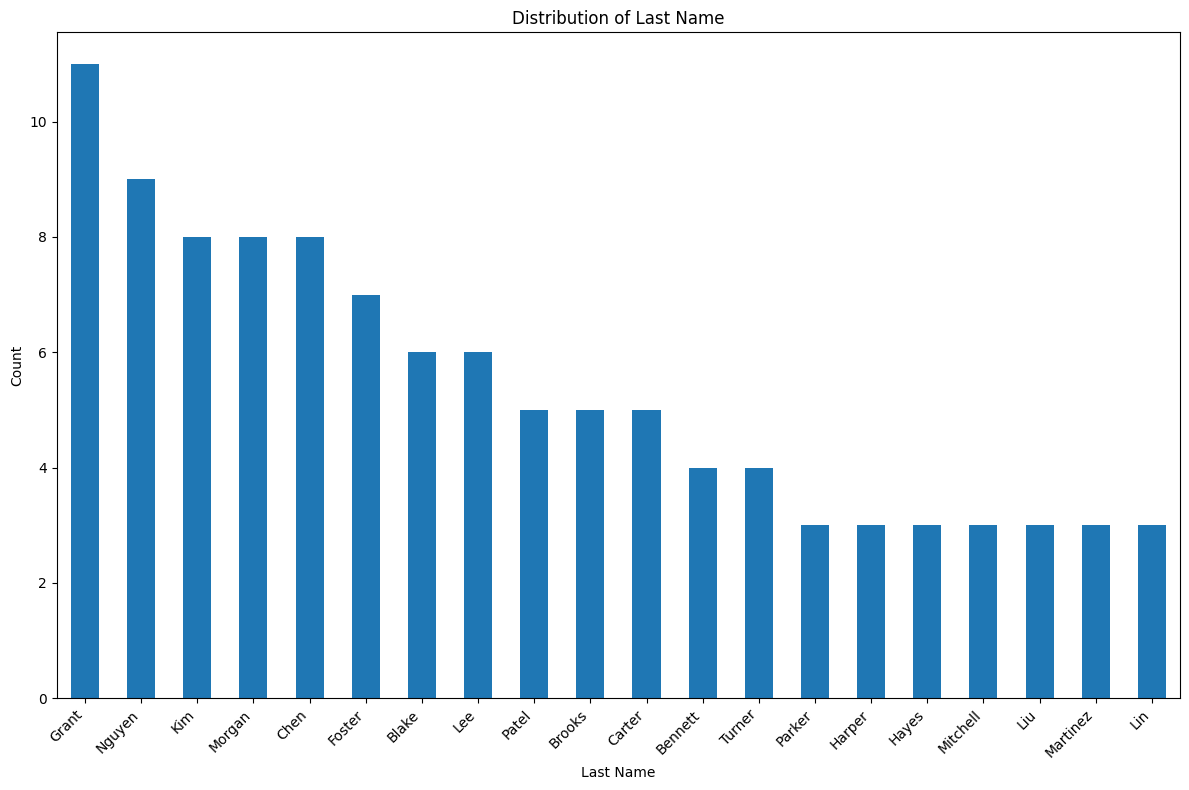

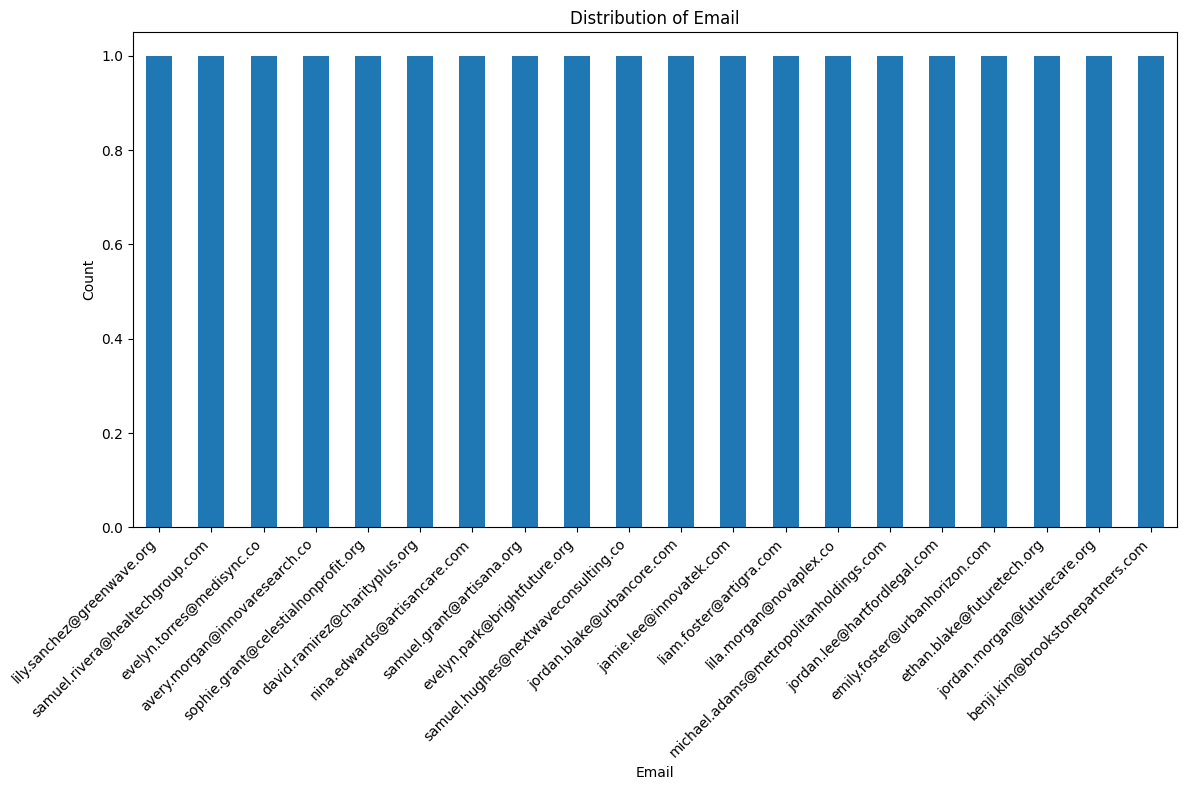

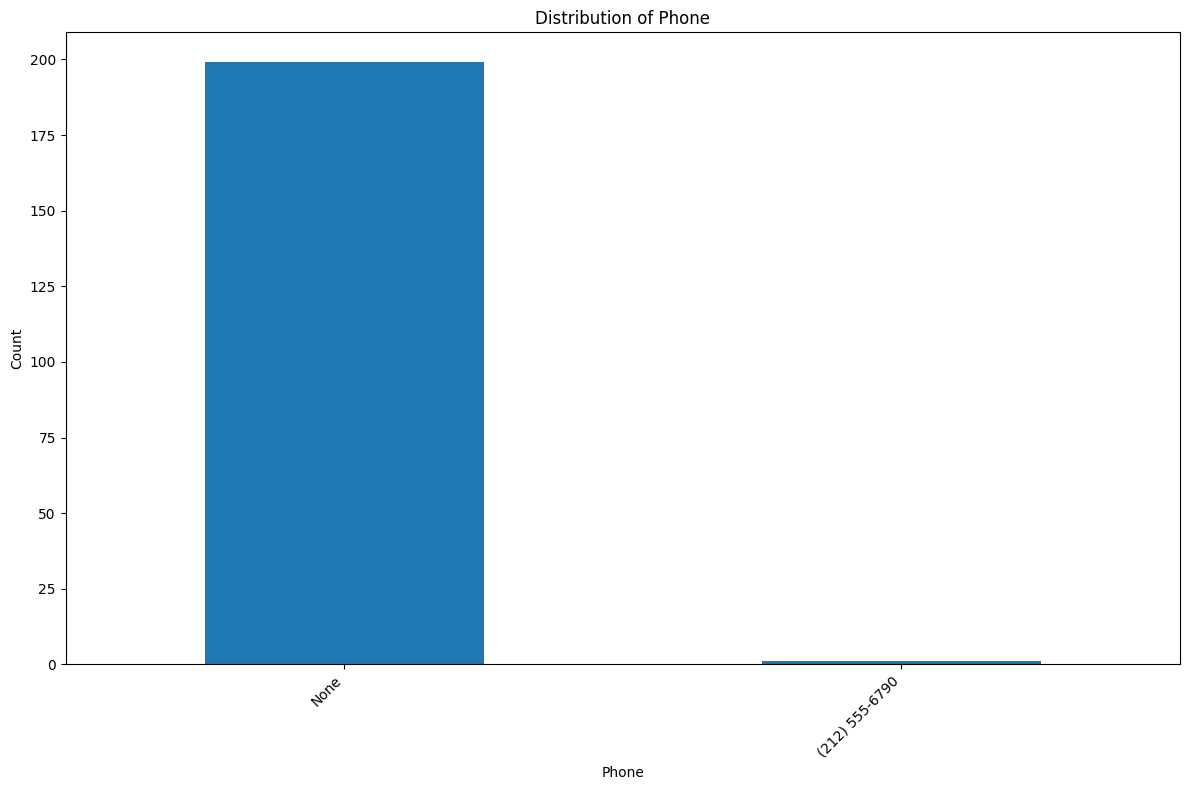

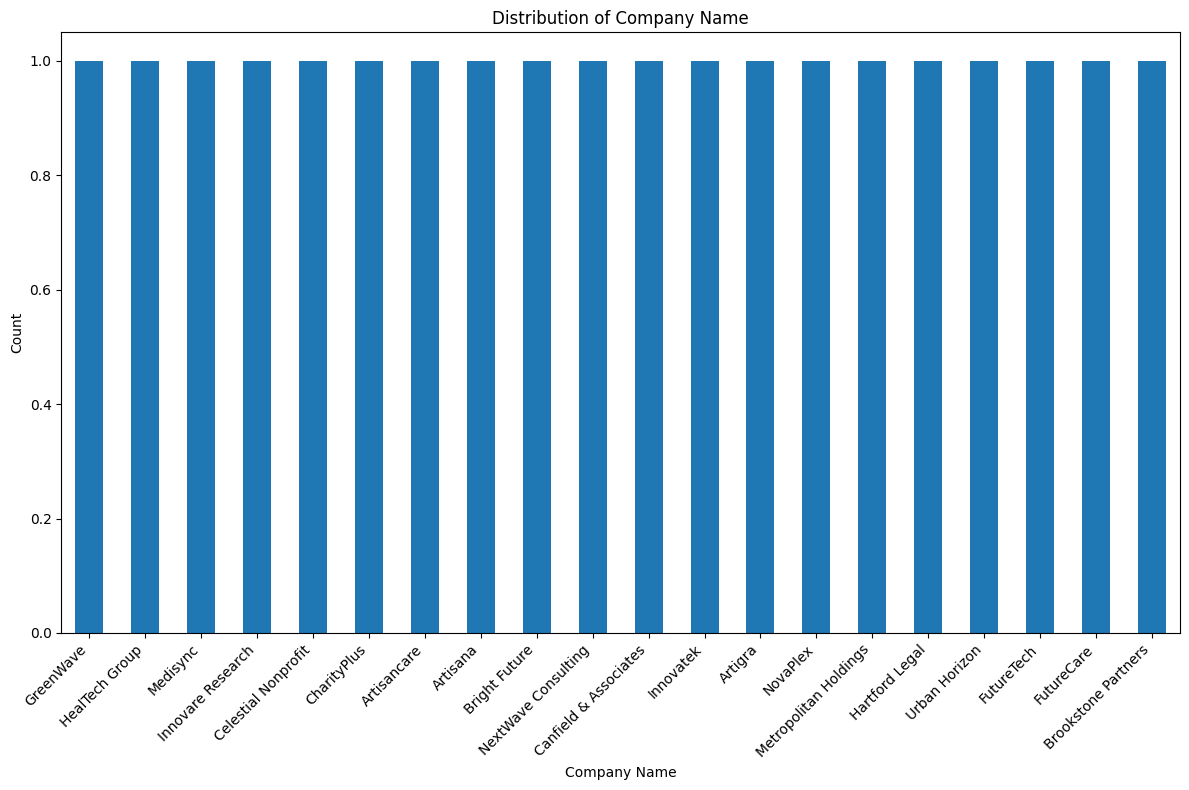

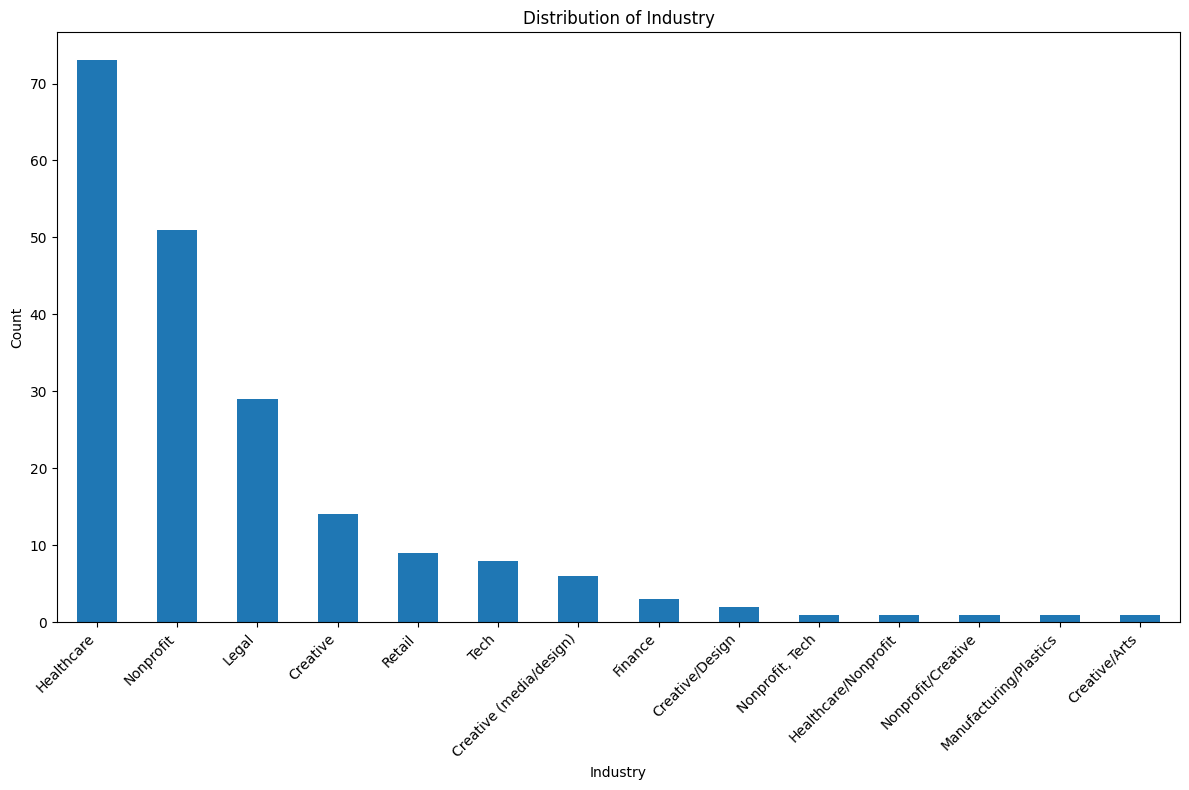

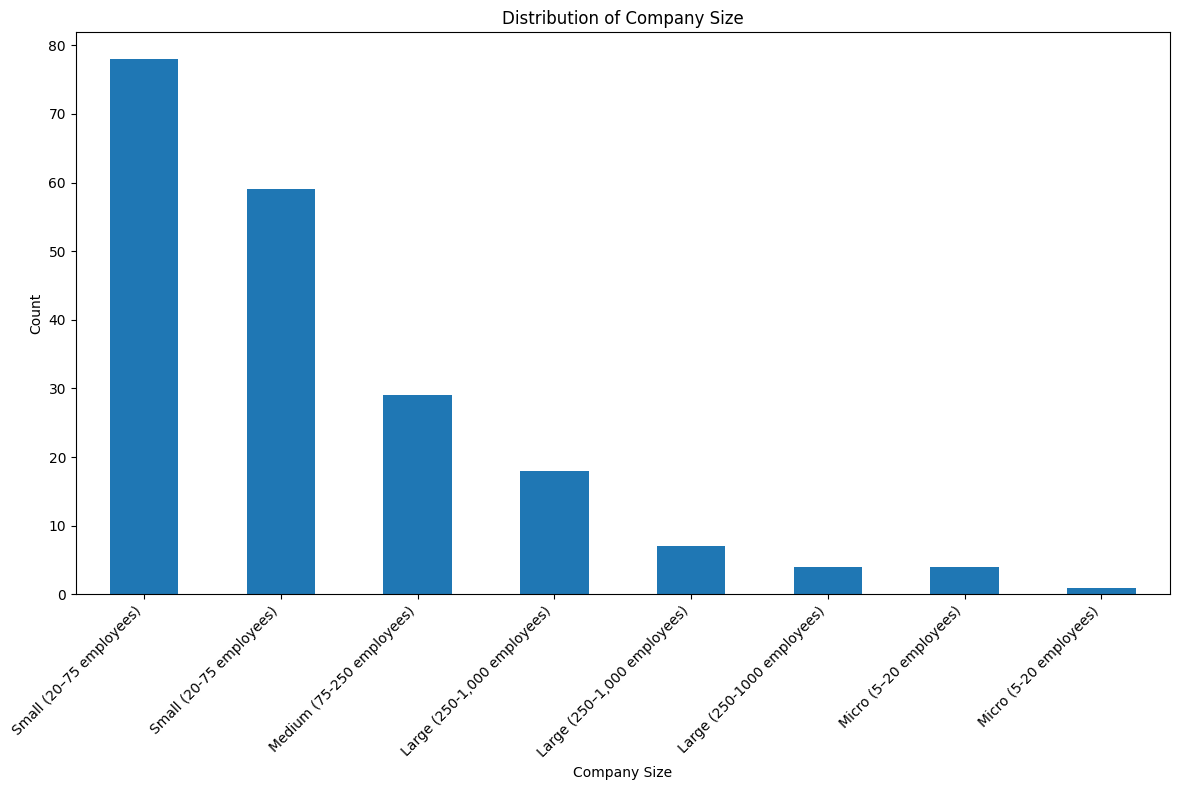

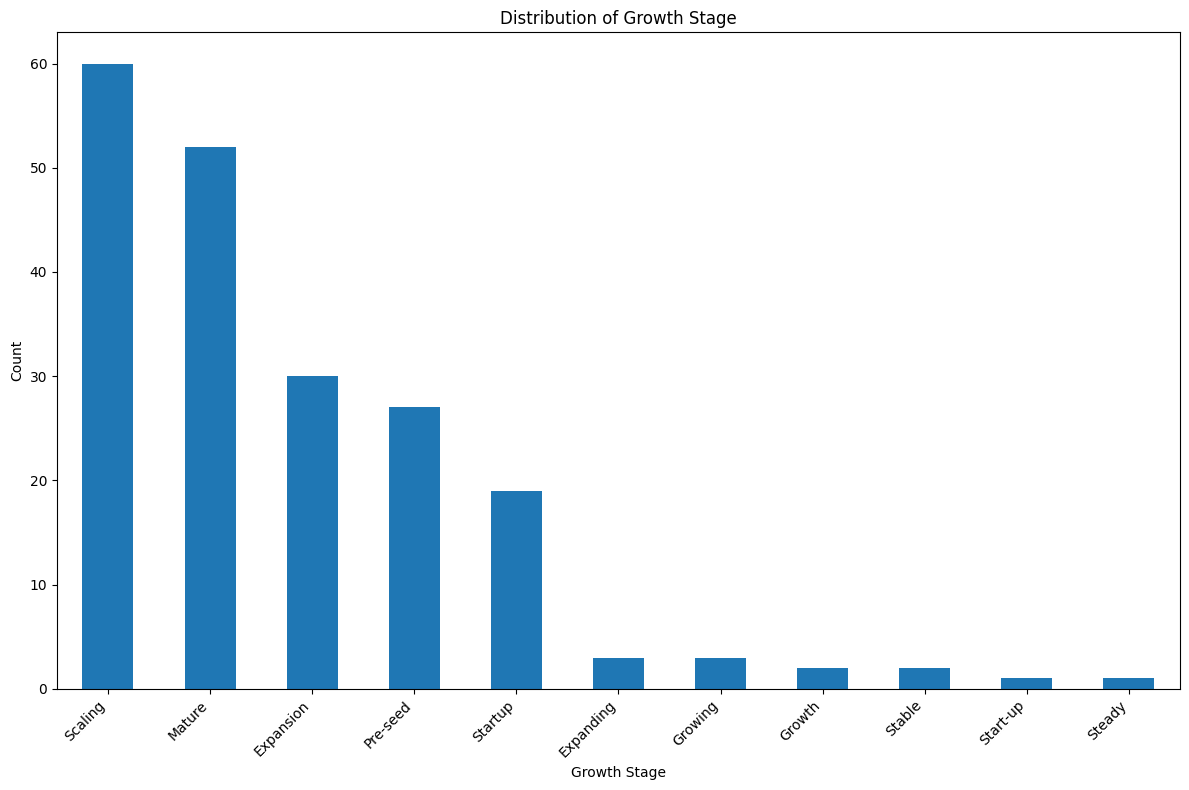

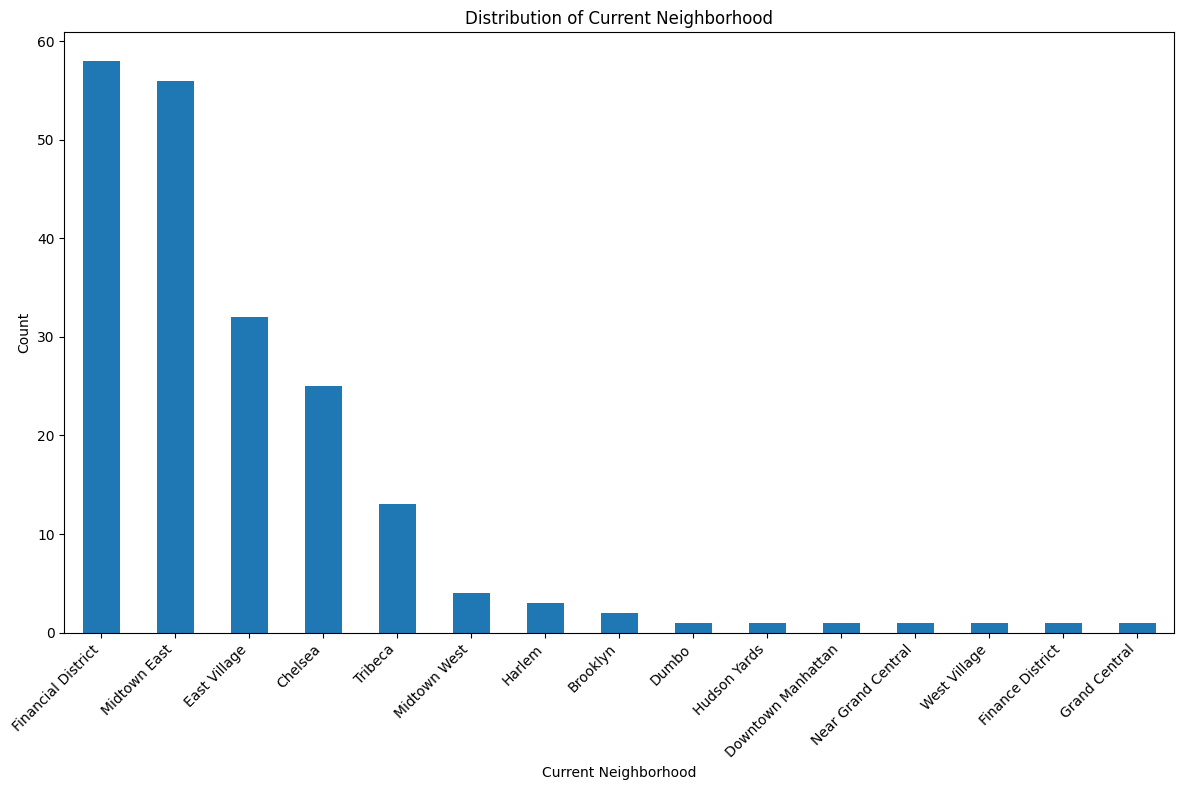

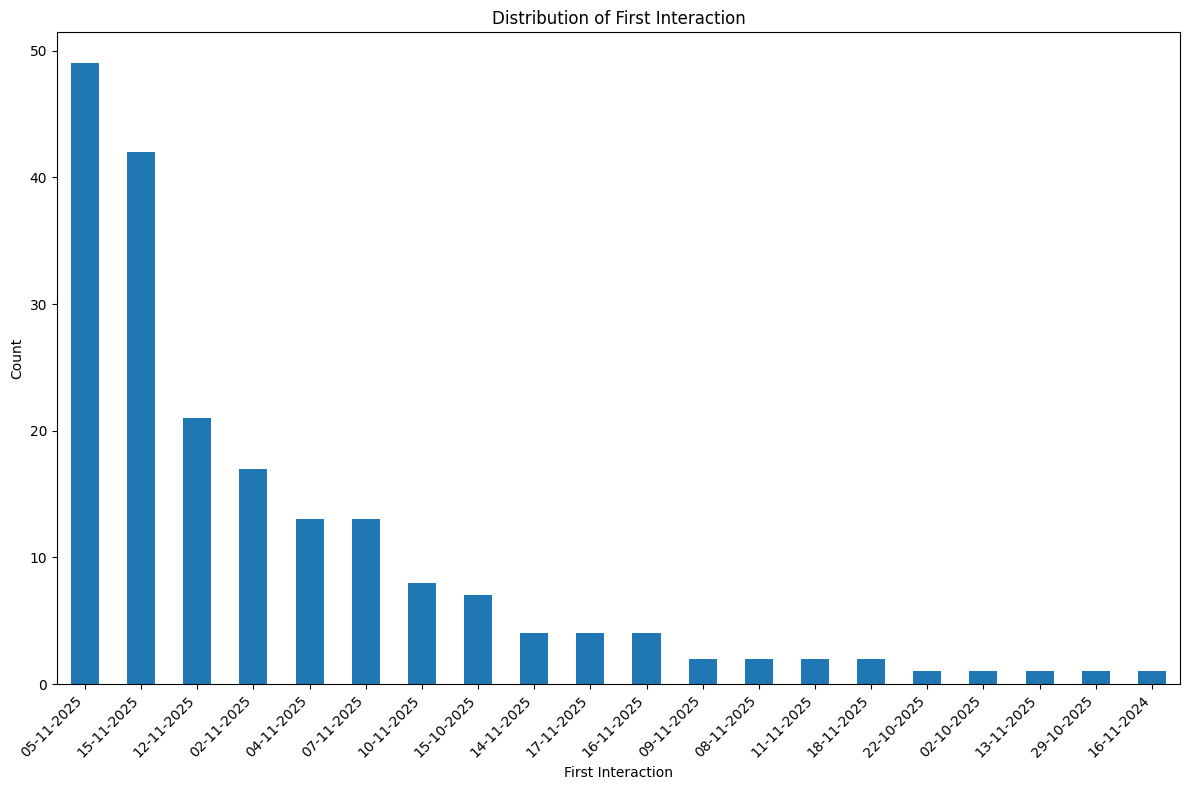

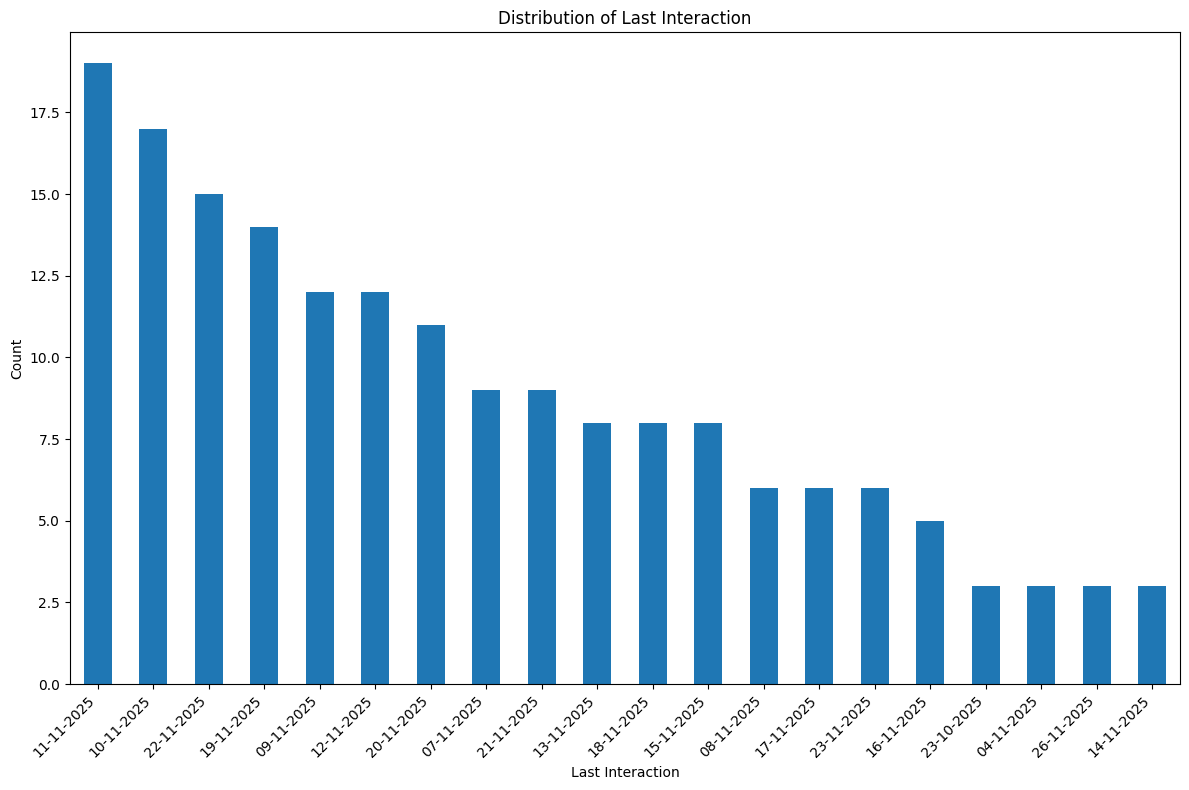

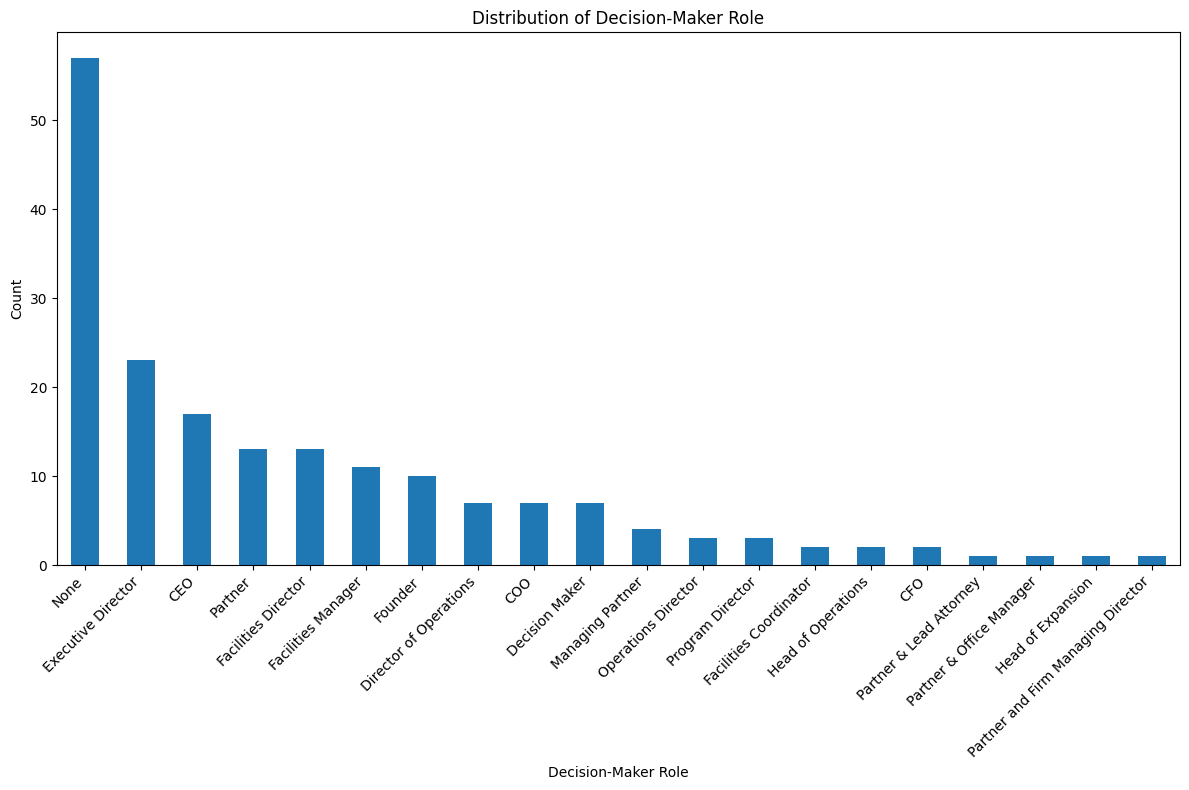

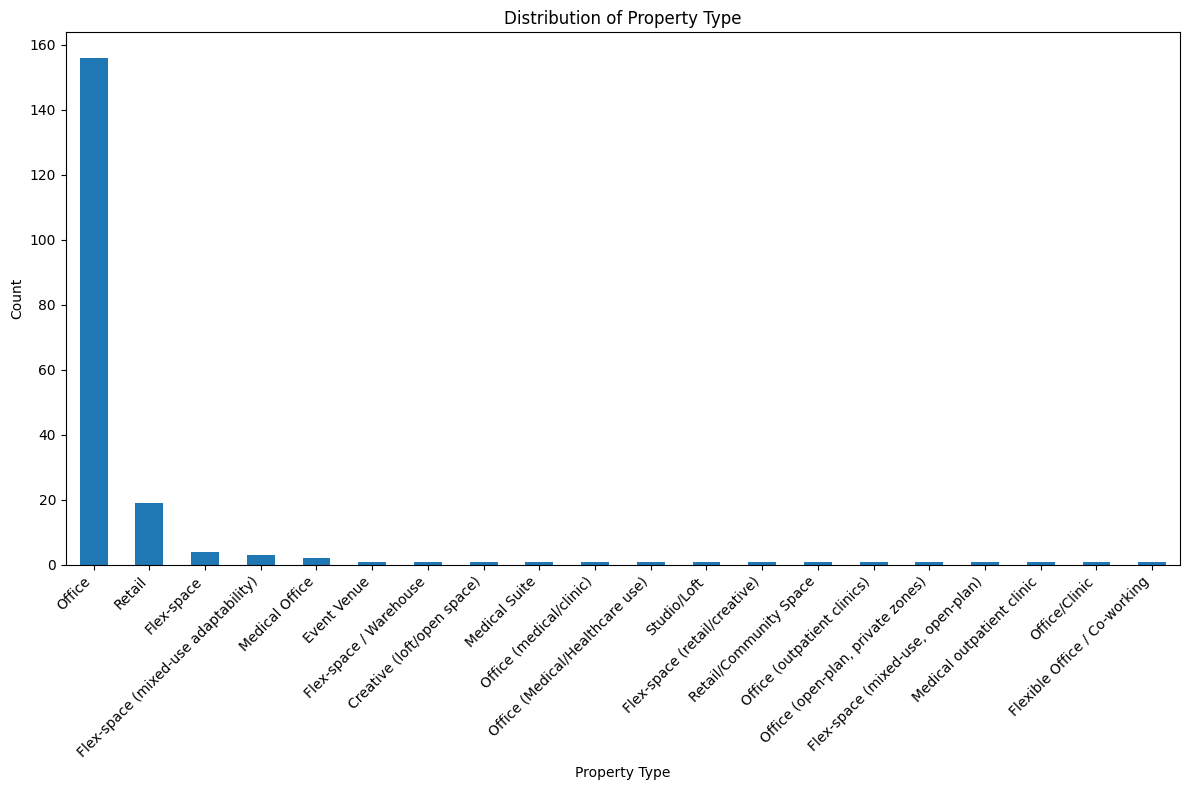

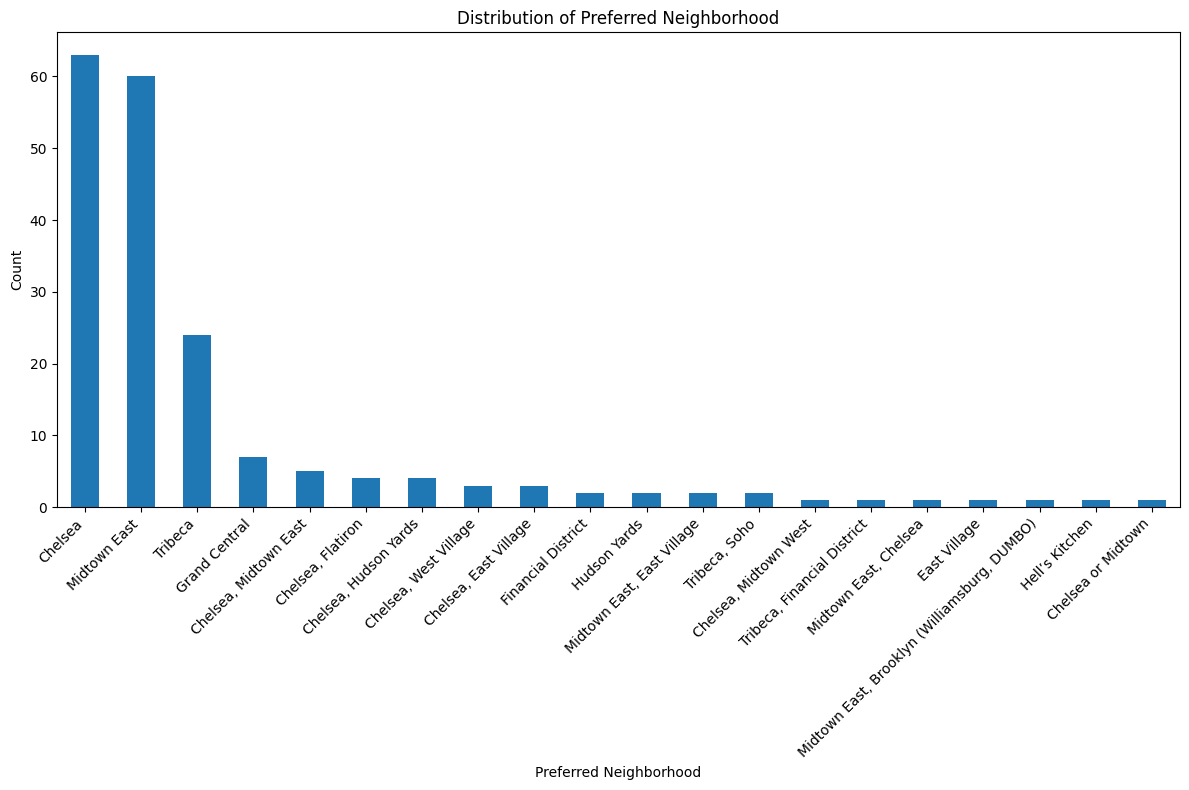

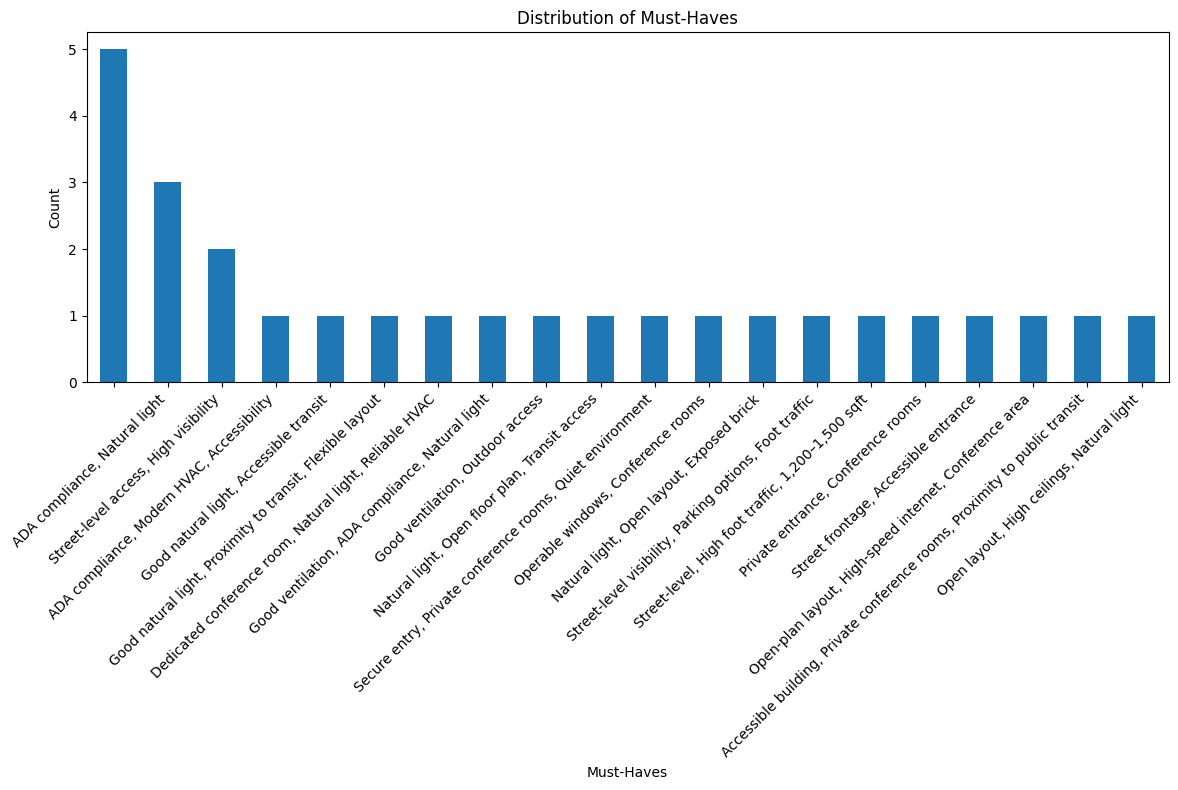

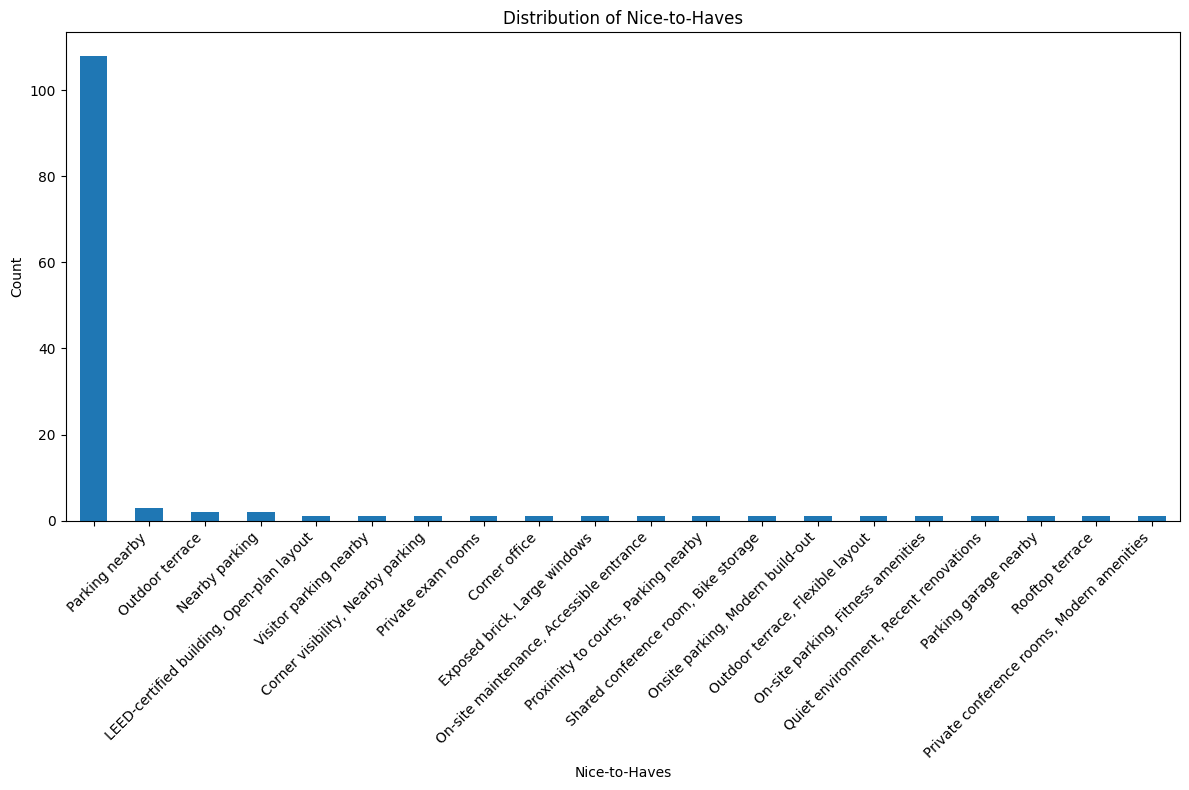

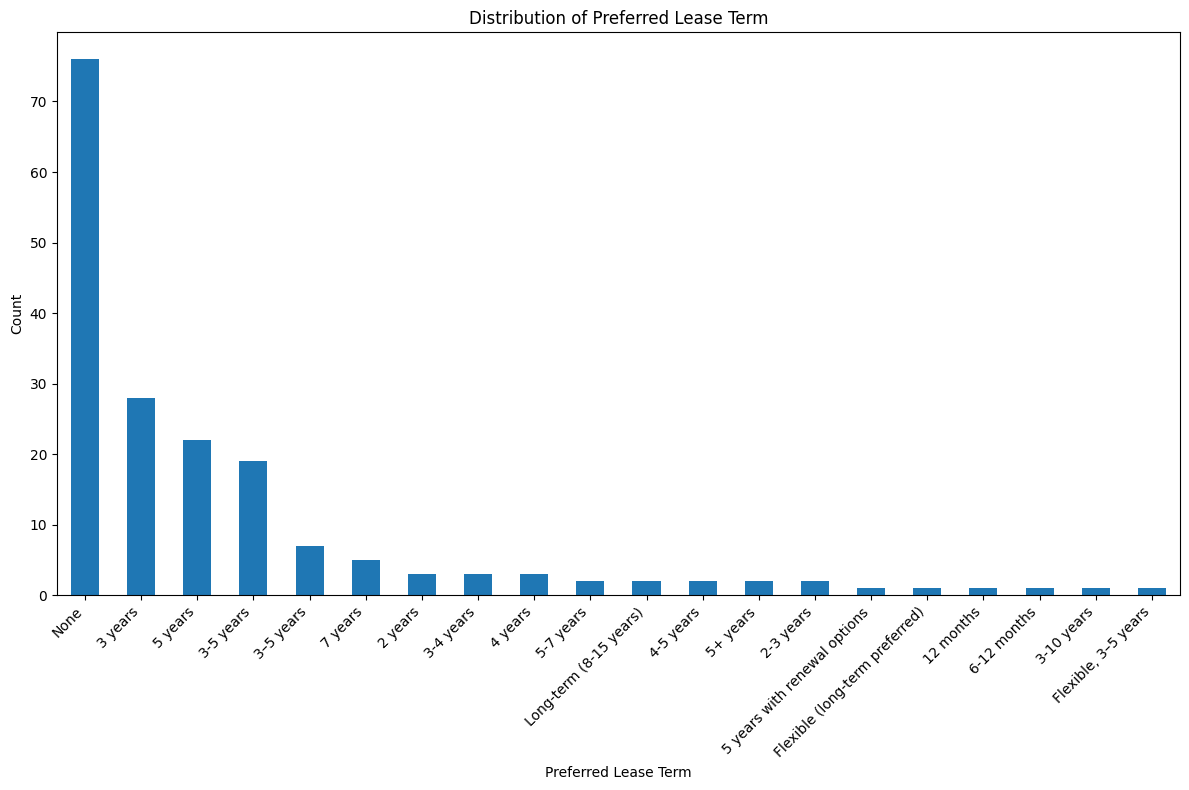

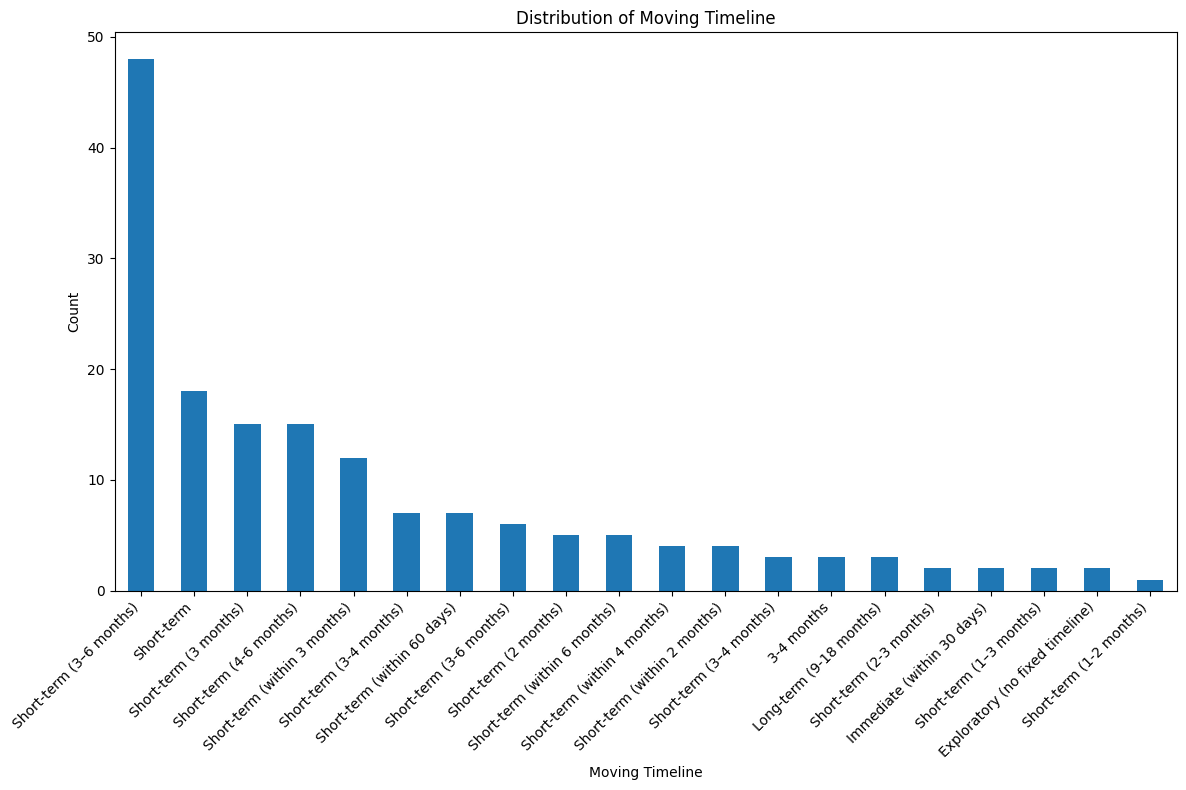

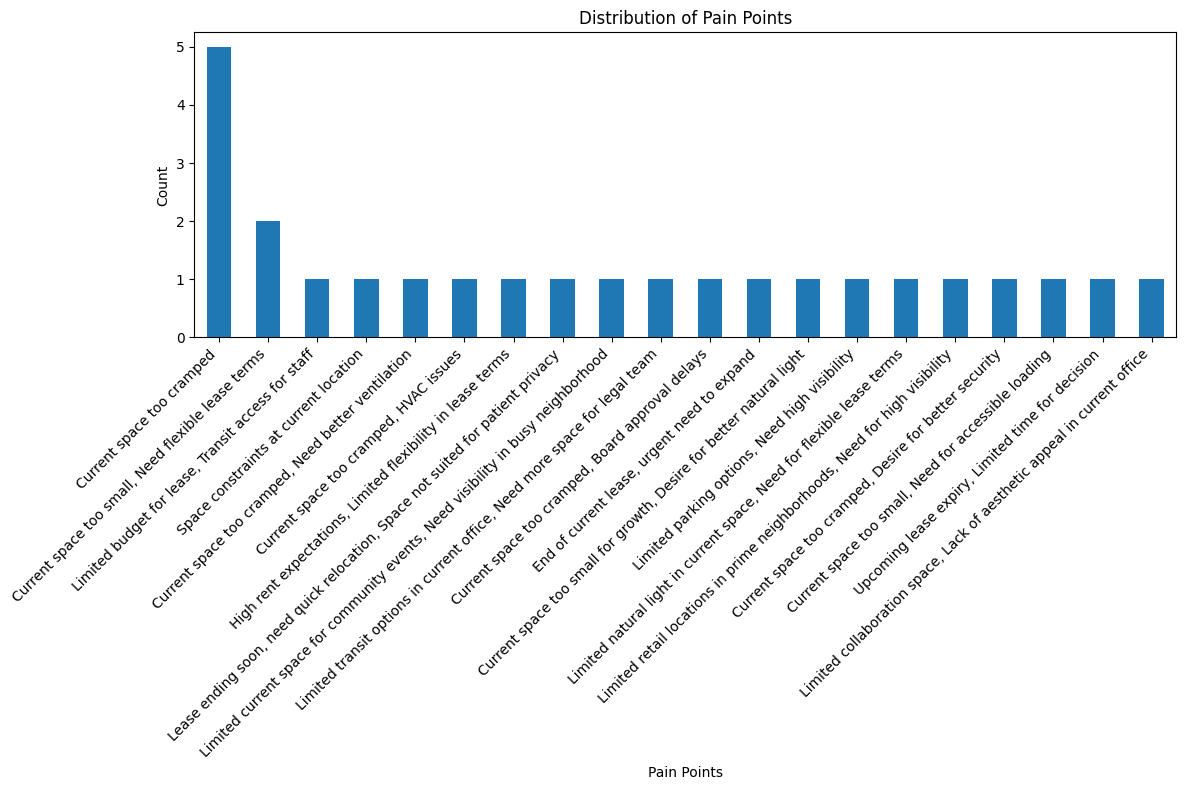

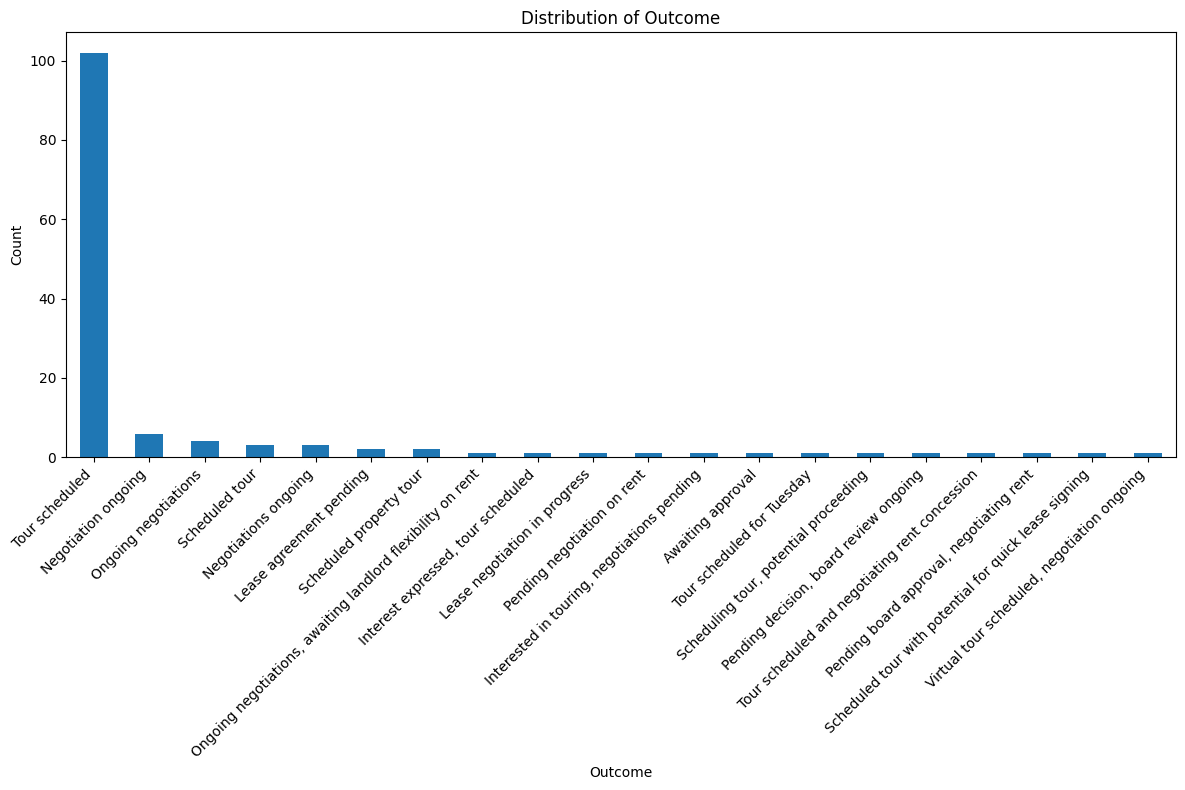

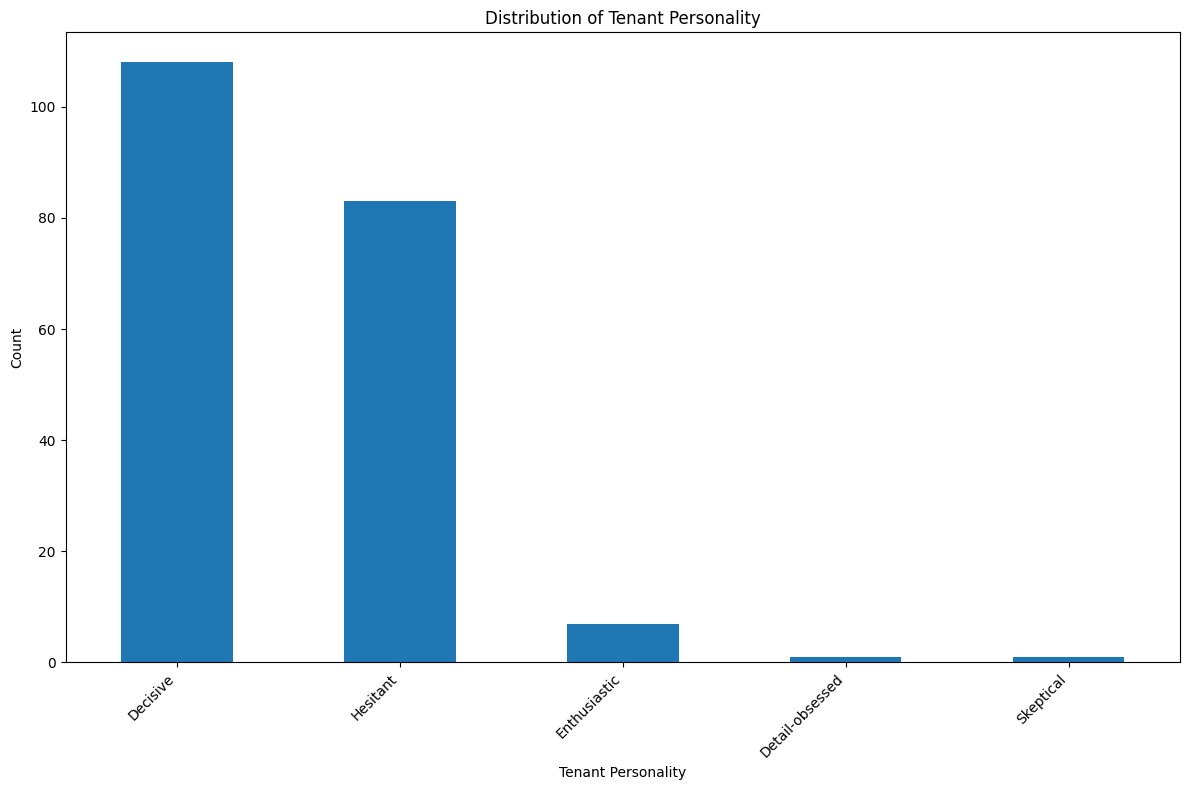

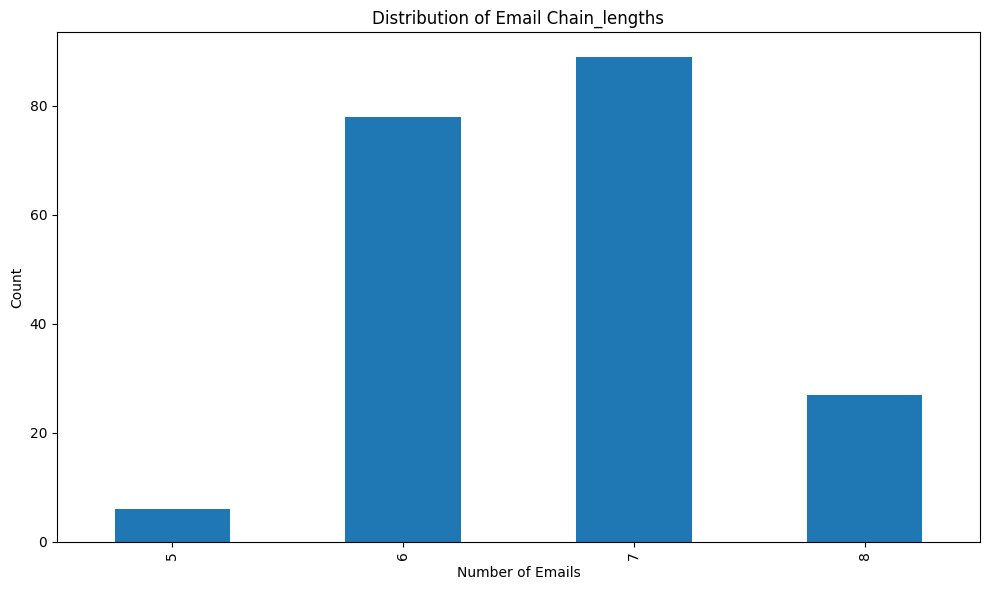

In [45]:
# Visualize distributions
visualize_distributions(results)

In [46]:
# Print summary
print("Dataset Diversity Summary:")
print(f"Number of chains: {results['num_chains']}")
for entity, dist in results["entity_distributions"].items():
    print(f"\n{entity}:")
    print(f"  Unique values: {dist.get('unique', dist.get('unique_raw'))}") # Use get to avoid KeyError
    print(f"  Missing values: {dist['missing']}")
    if entity in ["Estimated or Stated Budget", "Space Size"]:
        print(f"  Mean (normalized): {dist['normalized_mean']:.2f}")
        print(f"  Std (normalized): {dist['normalized_std']:.2f}")
        print(f"  Range (normalized): [{dist['normalized_min']}, {dist['normalized_max']}]")
    else:
        # Check if 'counts' key exists before accessing it
        if "counts" in dist:
            print("  All Unique Values:")  # Changed label
            for value, count in dist["counts"].items():  # Iterate through all items
                print(f"    {value}: {count}")
        else:
            print(f"  No 'counts' found for {entity}. It might be a numerical field.")

print("\nEmail Chain Length:")
print(f"  Mean: {results['email_chain_length']['mean']:.2f}")
print(f"  Std: {results['email_chain_length']['std']:.2f}")
print(f"  Range: [{results['email_chain_length']['min']}, {results['email_chain_length']['max']}]")

Dataset Diversity Summary:
Number of chains: 200

First Name:
  Unique values: 83
  Missing values: 0
  All Unique Values:
    Lily: 1
    Samuel: 6
    Evelyn: 5
    Avery: 1
    Sophie: 7
    David: 6
    Nina: 1
    Jordan: 22
    Jamie: 6
    Liam: 16
    Lila: 1
    Michael: 5
    Emily: 4
    Ethan: 6
    Benji: 3
    Marcus: 4
    Harper: 4
    Eric: 1
    Daniel: 6
    Olivia: 1
    Derek: 3
    Xavier: 1
    Morgan: 1
    Elliot: 1
    Nathaniel: 1
    Jasmine: 1
    Victoria: 1
    Taylor: 4
    Yvonne: 1
    Benjamin: 5
    Reed: 1
    Lena: 1
    Alex: 7
    Rachel: 2
    Grace: 1
    Ryan: 1
    Emma: 1
    Noah: 1
    Clara: 2
    Gina: 1
    Lisa: 1
    Lauren: 2
    Raj: 1
    Oliver: 1
    Sasha: 1
    Lara: 2
    Leo: 1
    Johnathan: 1
    Luke: 1
    Kevin: 3
    Alexandra: 1
    Rebekah: 1
    Markus: 1
    Patrick: 1
    Robert: 1
    Sophia: 3
    James: 1
    Samantha: 2
    Laura: 1
    Sienna: 1
    John: 1
    Julia: 2
    Evan: 3
    Elena: 1
    Priya: 1
  

Consolidated Neighborhood Diversity Summary:
Unique neighborhoods: 3
Missing values: 0
Top neighborhoods:
  Midtown West: 109
  Midtown East: 79
  Downtown: 51


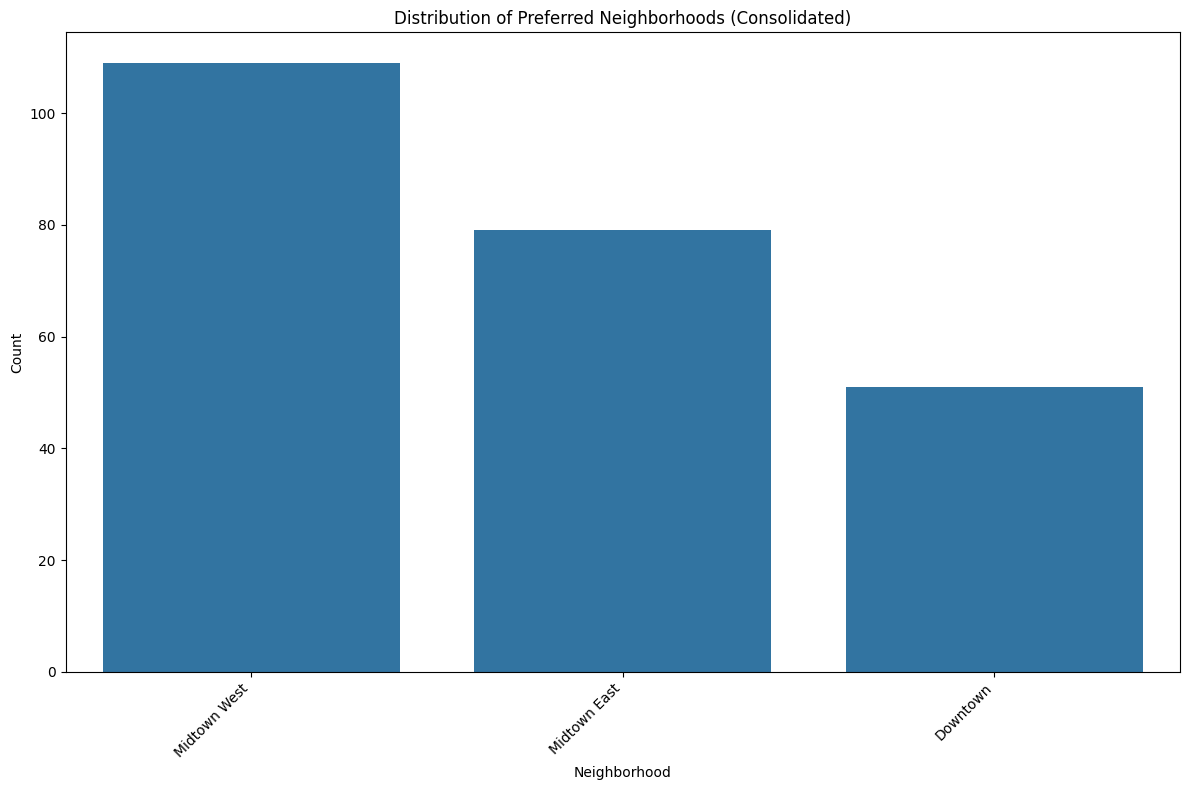

In [47]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_neighborhood(loc):
    """
    Normalize a neighborhood string by stripping whitespace, converting to title case,
    and cleaning up punctuation (e.g., parentheses, all curly apostrophes).

    Args:
        loc (str): The neighborhood string.

    Returns:
        str: Normalized neighborhood string.
    """
    if not isinstance(loc, str):
        return ""
    # Replace all curly apostrophes (U+2018, U+2019) with straight apostrophe
    loc = re.sub(r'[\u2018\u2019]', "'", loc)
    # Remove parenthetical content and normalize whitespace
    loc = re.sub(r'\s*\([^)]*\)\s*', '', loc)
    loc = loc.strip().title()
    return loc

def modify_neighborhoods(filename):
    """
    Modifies the 'Preferred Neighborhood' field in the JSON data to consolidate into three labels:
    Downtown, Midtown East, Midtown West. 'Midtown' is duplicated as both Midtown East and Midtown West.
    Preserves multi-label lists and normalizes strings.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    # Define consolidation mapping (using normalized keys)
    consolidation_map = {
        "West Village": "Downtown",
        "East Village": "Downtown",
        "Financial District": "Downtown",
        "Tribeca": "Downtown",
        "Soho": "Downtown",
        "Downtown Manhattan": "Downtown",
        "Downtown": "Downtown",
        "Brooklyn": "Downtown",
        "Williamsburg": "Downtown",
        "Dumbo": "Downtown",
        "Brooklyn (Williamsburg": "Downtown",
        "Dumbo)": "Downtown",
        "East Village Or Chelsea": "Downtown",
        "Midtown East": "Midtown East",
        "Grand Central": "Midtown East",
        "Chelsea": "Midtown West",
        "Hudson Yards": "Midtown West",
        "Midtown West": "Midtown West",
        "Hell's Kitchen": "Midtown West",
        "Hell'S Kitchen": "Midtown West",  # Explicitly include curly apostrophe variant
        "23Rd To 28Th Street": "Midtown West",
        "23Rd To 28Th Streets": "Midtown West",
        "Flatiron": "Midtown West",
        "Riverside Area": "Midtown West",
        "High Line": "Midtown West",
        "Chelsea Or Midtown": "Midtown West"
    }

    with open(filename, 'r') as f:
        data = json.load(f)

    for chain in data:
        profile = chain.get("tenant_profile", {})
        property_prefs = profile.get("Property Preferences", {})
        neighborhoods = property_prefs.get("Preferred Neighborhood", [])

        if neighborhoods:
            # Ensure neighborhoods is a list of strings
            if isinstance(neighborhoods, str):
                neighborhoods = [loc.strip() for loc in neighborhoods.split(',') if loc.strip()]
            # Normalize and replace each neighborhood
            updated_neighborhoods = []
            for loc in neighborhoods:
                normalized_loc = normalize_neighborhood(loc)
                if normalized_loc == "Midtown":
                    updated_neighborhoods.extend(["Midtown East", "Midtown West"])
                else:
                    updated_neighborhoods.append(consolidation_map.get(normalized_loc, normalized_loc))
            property_prefs["Preferred Neighborhood"] = updated_neighborhoods

    # Save the modified data back to the file
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def extract_neighborhoods(chain):
    """
    Extract Preferred Neighborhood as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of neighborhood strings.
    """
    profile = chain.get("tenant_profile", {})
    property_prefs = profile.get("Property Preferences", {})
    neighborhoods = property_prefs.get("Preferred Neighborhood", [])

    # Handle both list and string formats
    if isinstance(neighborhoods, str):
        return [loc.strip() for loc in neighborhoods.split(',') if loc.strip()]
    elif isinstance(neighborhoods, list):
        return [loc for loc in neighborhoods if isinstance(loc, str) and loc.strip()]
    return []

def analyze_neighborhood_diversity(data):
    """
    Analyze the diversity of Preferred Neighborhoods, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    neighborhoods = []
    for chain in data:
        neighborhoods.extend(extract_neighborhoods(chain))

    # Compute counts and stats
    counts = Counter(neighborhoods)
    results = {
        "Neighborhood": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_neighborhoods(chain))
        }
    }
    return results

def plot_neighborhood_distribution(results):
    """
    Plot the distribution of Preferred Neighborhoods.

    Args:
        results (dict): Analysis results from analyze_neighborhood_diversity.
    """
    neighborhood_counts = results["Neighborhood"]["counts"]
    if neighborhood_counts:
        # Sort by frequency (descending)
        sorted_neighborhoods = sorted(neighborhood_counts.items(), key=lambda x: x[1], reverse=True)
        locations = [loc for loc, count in sorted_neighborhoods]
        counts = [count for loc, count in sorted_neighborhoods]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=locations, y=counts)
        plt.title("Distribution of Preferred Neighborhoods (Consolidated)")
        plt.xlabel("Neighborhood")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('neighborhood_distribution_consolidated.png')

# Modify the JSON data
modify_neighborhoods("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
neighborhood_results = analyze_neighborhood_diversity(data)
plot_neighborhood_distribution(neighborhood_results)

# Print summary
print("Consolidated Neighborhood Diversity Summary:")
print(f"Unique neighborhoods: {neighborhood_results['Neighborhood']['unique']}")
print(f"Missing values: {neighborhood_results['Neighborhood']['missing']}")
print("Top neighborhoods:")
for loc, count in sorted(neighborhood_results["Neighborhood"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {loc}: {count}")

Consolidated Personality Diversity Summary:
Unique personalities: 2
Missing values: 0
Personality counts:
  Decisive: 115
  Hesitant: 85


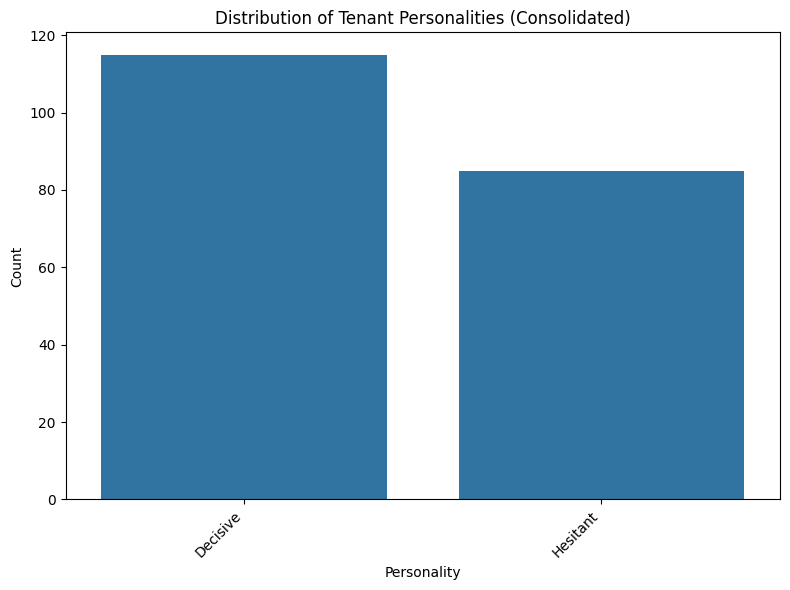

In [48]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_personality(personality):
    """
    Normalize a personality string by stripping whitespace and converting to title case.

    Args:
        personality (str): The personality string.

    Returns:
        str: Normalized personality string.
    """
    if not isinstance(personality, str):
        return ""
    # Normalize whitespace and convert to title case
    personality = re.sub(r'\s+', ' ', personality.strip()).title()
    # Handle hyphenated words consistently
    personality = personality.replace("Detail-Obsessed", "Detail-Obsessed")
    return personality

def modify_personalities(filename):
    """
    Modifies the 'Tenant Personality' field in the JSON data to consolidate into two labels:
    Decisive (Decisive, Enthusiastic) and Hesitant (Hesitant, Detail-Obsessed, Skeptical).
    Handles single or list values.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    # Define consolidation mapping
    consolidation_map = {
        "Decisive": "Decisive",
        "Enthusiastic": "Decisive",
        "Hesitant": "Hesitant",
        "Detail-Obsessed": "Hesitant",
        "Skeptical": "Hesitant"
    }

    with open(filename, 'r') as f:
        data = json.load(f)

    for chain in data:
        profile = chain.get("tenant_profile", {})
        personality = profile.get("Tenant Personality", "")

        if personality:
            # Handle both string and list cases
            if isinstance(personality, str):
                personalities = [personality]
            elif isinstance(personality, list):
                personalities = personality
            else:
                personalities = []

            # Normalize and replace each personality
            updated_personalities = []
            for p in personalities:
                normalized_p = normalize_personality(p)
                if normalized_p in consolidation_map:
                    updated_personalities.append(consolidation_map[normalized_p])
                else:
                    updated_personalities.append(normalized_p)

            # Store as a single string if only one personality, otherwise keep as list
            profile["Tenant Personality"] = updated_personalities[0] if len(updated_personalities) == 1 else updated_personalities

    # Save the modified data back to the file
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def extract_personalities(chain):
    """
    Extract Tenant Personality as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of personality strings.
    """
    profile = chain.get("tenant_profile", {})
    personality = profile.get("Tenant Personality", "")

    # Handle both string and list formats
    if isinstance(personality, str):
        return [personality] if personality.strip() else []
    elif isinstance(personality, list):
        return [p for p in personality if isinstance(p, str) and p.strip()]
    return []

def analyze_personality_diversity(data):
    """
    Analyze the diversity of Tenant Personalities, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    personalities = []
    for chain in data:
        personalities.extend(extract_personalities(chain))

    # Compute counts and stats
    counts = Counter(personalities)
    results = {
        "Personality": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_personalities(chain))
        }
    }
    return results

def plot_personality_distribution(results):
    """
    Plot the distribution of Tenant Personalities.

    Args:
        results (dict): Analysis results from analyze_personality_diversity.
    """
    personality_counts = results["Personality"]["counts"]
    if personality_counts:
        # Sort by frequency (descending)
        sorted_personalities = sorted(personality_counts.items(), key=lambda x: x[1], reverse=True)
        personalities = [p for p, count in sorted_personalities]
        counts = [count for p, count in sorted_personalities]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=personalities, y=counts)
        plt.title("Distribution of Tenant Personalities (Consolidated)")
        plt.xlabel("Personality")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('personality_distribution_consolidated.png')

# Modify the JSON data
modify_personalities("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
personality_results = analyze_personality_diversity(data)
plot_personality_distribution(personality_results)

# Print summary
print("Consolidated Personality Diversity Summary:")
print(f"Unique personalities: {personality_results['Personality']['unique']}")
print(f"Missing values: {personality_results['Personality']['missing']}")
print("Personality counts:")
for p, count in sorted(personality_results["Personality"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {p}: {count}")

Consolidated Industry Diversity Summary:
Unique industries: 6
Missing values: 0
Industry counts:
  Healthcare: 74
  Nonprofit: 54
  Creative: 34
  Legal: 29
  Tech: 9
  Finance: 3


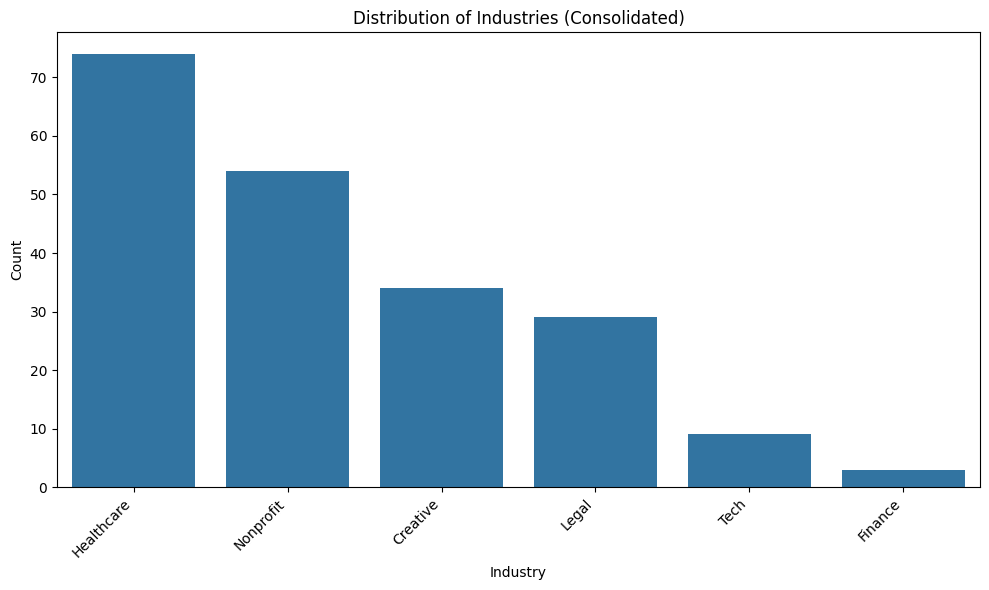

In [49]:
def normalize_industry(industry):
    """
    Normalize an industry string by splitting comma-separated values, stripping whitespace,
    and converting to title case.

    Args:
        industry (str): The industry string.

    Returns:
        list: List of normalized industry strings.
    """
    if not isinstance(industry, str):
        return []
    # Split on commas for multi-industry strings
    industries = [ind.strip() for ind in industry.split(',') if ind.strip()]
    # Normalize each industry
    normalized = []
    for ind in industries:
        ind = re.sub(r'\s+', ' ', ind).title()
        # Standardize specific formats
        ind = ind.replace("Healthcare/Nonprofit", "Healthcare/Nonprofit")
        ind = ind.replace("Nonprofit/Creative", "Nonprofit/Creative")
        ind = ind.replace("Creative (Media/Design)", "Creative (Media/Design)")
        ind = ind.replace("Creative/Design", "Creative/Design")
        ind = ind.replace("Creative/Arts", "Creative/Arts")
        ind = ind.replace("Manufacturing/Plastics", "Manufacturing/Plastics")
        normalized.append(ind)
    return normalized

def get_industry(chain):
    """
    Attempt to extract Industry from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str or list: Industry value, or empty string/list if not found.
    """
    profile = chain.get("tenant_profile", {})

    # Try multiple possible paths
    possible_paths = [
        profile.get("Industry"),
        profile.get("Company Details", {}).get("Industry"),
        profile.get("Tenant Details", {}).get("Industry"),
        profile.get("Company", {}).get("Industry")
    ]

    for industry in possible_paths:
        if industry:
            return industry

    return ""

def modify_industries(filename):
    """
    Modifies the 'Industry' field in the JSON data to consolidate into six labels:
    Healthcare, Nonprofit, Legal, Creative, Tech, Finance. 'Healthcare/Nonprofit' contributes
    to both Healthcare and Nonprofit; 'Nonprofit/Creative' to both Nonprofit and Creative.
    Splits comma-separated industries like 'Nonprofit, Tech'.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    # Define consolidation mapping
    consolidation_map = {
        "Healthcare": ["Healthcare"],
        "Healthcare/Nonprofit": ["Healthcare", "Nonprofit"],
        "Nonprofit": ["Nonprofit"],
        "Nonprofit/Creative": ["Nonprofit", "Creative"],
        "Legal": ["Legal"],
        "Retail": ["Creative"],
        "Creative (Media/Design)": ["Creative"],
        "Creative/Design": ["Creative"],
        "Manufacturing/Plastics": ["Creative"],
        "Creative/Arts": ["Creative"],
        "Tech": ["Tech"],
        "Finance": ["Finance"]
    }

    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    industries_found = False

    for chain in data:
        industry = get_industry(chain)
        profile = chain.get("tenant_profile", {})

        if industry:
            industries_found = True
            # Handle both string and list cases
            if isinstance(industry, str):
                industries = [industry]
            elif isinstance(industry, list):
                industries = industry
            else:
                industries = []

            # Normalize and replace each industry
            updated_industries = []
            for ind in industries:
                normalized_inds = normalize_industry(ind)
                for normalized_ind in normalized_inds:
                    if normalized_ind in consolidation_map:
                        updated_industries.extend(consolidation_map[normalized_ind])
                    else:
                        updated_industries.append(normalized_ind)

            # Store in the original location
            profile["Industry"] = updated_industries[0] if len(updated_industries) == 1 else updated_industries
        else:
            # Collect sample for debugging
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    # Save the modified data back to the file
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    # Print debugging info if no industries found
    if not industries_found:
        print("WARNING: No industries found in the dataset. Possible reasons:")
        print("1. 'Industry' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_industries(chain):
    """
    Extract Industry as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of industry strings.
    """
    industry = get_industry(chain)

    # Handle both string and list formats
    if isinstance(industry, str):
        return normalize_industry(industry) if industry.strip() else []
    elif isinstance(industry, list):
        industries = []
        for ind in industry:
            industries.extend(normalize_industry(ind))
        return [ind for ind in industries if ind.strip()]
    return []

def analyze_industry_diversity(data):
    """
    Analyze the diversity of Industries, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    industries = []
    for chain in data:
        industries.extend(extract_industries(chain))

    # Compute counts and stats
    counts = Counter(industries)
    results = {
        "Industry": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_industries(chain))
        }
    }
    return results

def plot_industry_distribution(results):
    """
    Plot the distribution of Industries.

    Args:
        results (dict): Analysis results from analyze_industry_diversity.
    """
    industry_counts = results["Industry"]["counts"]
    if industry_counts:
        # Sort by frequency (descending)
        sorted_industries = sorted(industry_counts.items(), key=lambda x: x[1], reverse=True)
        industries = [ind for ind, count in sorted_industries]
        counts = [count for ind, count in sorted_industries]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=industries, y=counts)
        plt.title("Distribution of Industries (Consolidated)")
        plt.xlabel("Industry")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('industry_distribution_consolidated.png')
    else:
        print("No industries to plot.")

# Modify the JSON data
modify_industries("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
industry_results = analyze_industry_diversity(data)
plot_industry_distribution(industry_results)

# Print summary
print("Consolidated Industry Diversity Summary:")
print(f"Unique industries: {industry_results['Industry']['unique']}")
print(f"Missing values: {industry_results['Industry']['missing']}")
print("Industry counts:")
for ind, count in sorted(industry_results["Industry"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {ind}: {count}")

Consolidated Moving Term Diversity Summary:
Unique moving terms: 4
Missing values: 0
Moving Term counts:
  Prompt: 154
  Swift: 28
  Steady: 11
  Horizon: 7


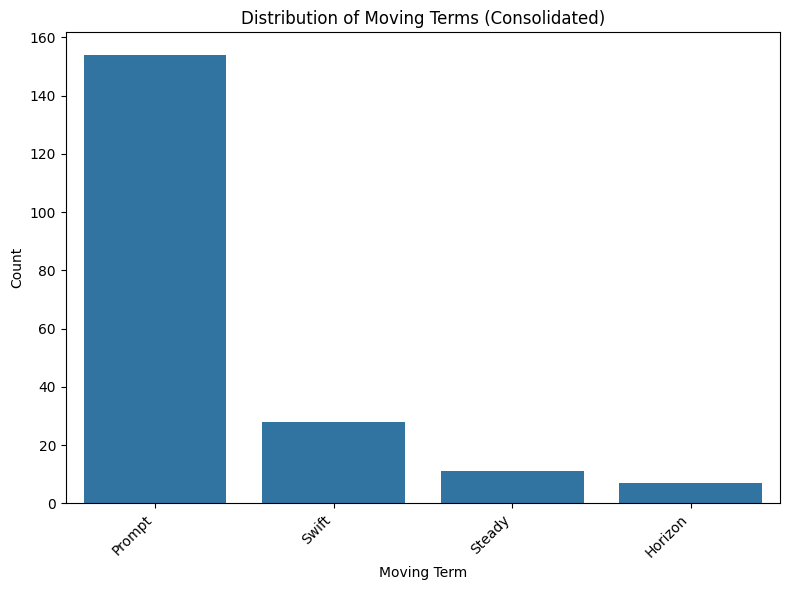

In [50]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_timeline(timeline):
    """
    Normalize a timeline string by stripping whitespace and standardizing format.

    Args:
        timeline (str): The timeline string.

    Returns:
        str: Normalized timeline string.
    """
    if not isinstance(timeline, str):
        return ""
    timeline = re.sub(r'\s+', ' ', timeline.strip()).lower()
    timeline = timeline.replace('–', '-').replace('’', "'")
    return timeline

def map_timeline(timeline):
    """
    Map a timeline to Moving Term and Moving Timing.

    Args:
        timeline (str): The timeline string.

    Returns:
        dict: {moving_term, moving_timing: {min_months, max_months}}
    """
    normalized = normalize_timeline(timeline)

    # Define mapping
    timeline_map = {
        # Swift (0-2 months)
        "immediate (within 30 days)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},
        "immediate (30 days)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},
        "immediate (within 1 month)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},
        "short-term (within 1 month)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},
        "short-term (within 30 days)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},
        "short-term (within 45 days)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1.5}},
        "short-term (within 60 days)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 2}},
        "short-term (within 60 days, ideally by mid-jan)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 2}},
        "short-term (within 2 months)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 2}},
        "short-term (1-2 months)": {"term": "Swift", "timing": {"min_months": 1, "max_months": 2}},
        "short-term (2 months)": {"term": "Swift", "timing": {"min_months": 2, "max_months": 2}},
        "within 60 days": {"term": "Swift", "timing": {"min_months": 0, "max_months": 2}},
        "short-term (by end of dec)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 2}},
        "short-term (mid-november)": {"term": "Swift", "timing": {"min_months": 0, "max_months": 1}},

        # Prompt (2-6 months)
        "short-term (3-6 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 6}},
        "short-term": {"term": "Prompt", "timing": {"min_months": 2, "max_months": 6}},
        "short-term (3 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 3}},
        "short-term (4-6 months)": {"term": "Prompt", "timing": {"min_months": 4, "max_months": 6}},
        "short-term (within 3 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 3}},
        "short-term (3-4 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 4}},
        "short-term (3-4 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 4}},
        "short-term (2-3 months)": {"term": "Prompt", "timing": {"min_months": 2, "max_months": 3}},
        "short-term (1-3 months)": {"term": "Prompt", "timing": {"min_months": 1, "max_months": 3}},
        "short-term (within 4 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 4}},
        "short-term (within 6 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 6}},
        "short-term (less than 3 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 3}},
        "short-term (less than 6 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 6}},
        "short-term (4-6 months)": {"term": "Prompt", "timing": {"min_months": 4, "max_months": 6}},
        "short-term (6 months)": {"term": "Prompt", "timing": {"min_months": 6, "max_months": 6}},
        "short-term (next quarter)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 6}},
        "short-term (within 6 weeks)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 1.5}},
        "short-term (within 8 weeks)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 2}},
        "3-4 months": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 4}},
        "4-6 months": {"term": "Prompt", "timing": {"min_months": 4, "max_months": 6}},
        "short-term (before q2 2026)": {"term": "Prompt", "timing": {"min_months": 6, "max_months": 11}},
        "short-term (end of february)": {"term": "Prompt", "timing": {"min_months": 9, "max_months": 9}},
        "medium (3-6 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 6}},
        "medium-term (3-6 months)": {"term": "Prompt", "timing": {"min_months": 3, "max_months": 6}},
        "flexible (within 6 months)": {"term": "Prompt", "timing": {"min_months": 0, "max_months": 6}},

        # Steady (6-12 months)
        "long-term (6-9 months)": {"term": "Steady", "timing": {"min_months": 6, "max_months": 9}},
        "short-term (6-9 months)": {"term": "Steady", "timing": {"min_months": 6, "max_months": 9}},
        "short-term (within 9 months)": {"term": "Steady", "timing": {"min_months": 0, "max_months": 9}},
        "moderate (8-12 months)": {"term": "Steady", "timing": {"min_months": 8, "max_months": 12}},
        "nearing lease expiry (9 months)": {"term": "Steady", "timing": {"min_months": 9, "max_months": 9}},
        "9-12 months (q2 move-in target)": {"term": "Steady", "timing": {"min_months": 9, "max_months": 12}},
        "early january": {"term": "Steady", "timing": {"min_months": 8, "max_months": 8}},
        "mid-january (short-term)": {"term": "Steady", "timing": {"min_months": 8, "max_months": 8}},
        "early next year": {"term": "Steady", "timing": {"min_months": 8, "max_months": 10}},
        "mid-december": {"term": "Steady", "timing": {"min_months": 7, "max_months": 7}},
        "short-term (before jan 15, 2026)": {"term": "Steady", "timing": {"min_months": 8, "max_months": 8}},

        # Horizon (12+ months or vague)
        "long-term (9-18 months)": {"term": "Horizon", "timing": {"min_months": 9, "max_months": 18}},
        "exploratory (no fixed timeline)": {"term": "Horizon", "timing": {"min_months": 12, "max_months": 24}},
        "moderate urgency (lease expiring march 2026)": {"term": "Horizon", "timing": {"min_months": 10, "max_months": 10}},
        "hesitant": {"term": "Horizon", "timing": {"min_months": 12, "max_months": 24}}
    }

    return timeline_map.get(normalized, {"term": "Horizon", "timing": {"min_months": 12, "max_months": 24}})

def get_timeline(chain):
    """
    Attempt to extract Moving Timeline from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str or list: Moving Timeline value, or empty string if not found.
    """
    profile = chain.get("tenant_profile", {})

    # Try multiple possible paths
    possible_paths = [
        profile.get("Property Preferences", {}).get("Moving Timeline"),
        profile.get("Moving Timeline"),
        profile.get("Tenant Details", {}).get("Moving Timeline"),
        profile.get("Preferences", {}).get("Moving Timeline")
    ]

    for timeline in possible_paths:
        if timeline:
            return timeline

    return ""

def modify_timelines(filename):
    """
    Modifies the 'Moving Timeline' field in the JSON data to add Moving Term (Swift, Prompt, Steady, Horizon)
    and Moving Timing (min_months, max_months). Preserves the original Moving Timeline.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    timelines_found = False

    for chain in data:
        timeline = get_timeline(chain)
        profile = chain.get("tenant_profile", {})
        property_prefs = profile.get("Property Preferences", {})

        if timeline:
            timelines_found = True
            # Handle string or list
            if isinstance(timeline, str):
                timelines = [timeline]
            elif isinstance(timeline, list):
                timelines = timeline
            else:
                timelines = []

            # Map the first timeline
            if timelines:
                mapped = map_timeline(timelines[0])
                property_prefs["Moving Term"] = mapped["term"]
                property_prefs["Moving Timing"] = mapped["timing"]
        else:
            # Collect sample for debugging
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    # Save the modified data
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    # Print debugging info if no timelines found
    if not timelines_found:
        print("WARNING: No Moving Timeline values found in the dataset. Possible reasons:")
        print("1. 'Moving Timeline' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_moving_terms(chain):
    """
    Extract Moving Term as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of moving term strings.
    """
    profile = chain.get("tenant_profile", {})
    property_prefs = profile.get("Property Preferences", {})
    term = property_prefs.get("Moving Term", "")
    return [term] if term else []

def analyze_timeline_diversity(data):
    """
    Analyze the diversity of Moving Terms, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    terms = []
    for chain in data:
        terms.extend(extract_moving_terms(chain))

    # Compute counts and stats
    counts = Counter(terms)
    results = {
        "Moving Term": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_moving_terms(chain))
        }
    }
    return results

def plot_timeline_distribution(results):
    """
    Plot the distribution of Moving Terms.

    Args:
        results (dict): Analysis results from analyze_timeline_diversity.
    """
    term_counts = results["Moving Term"]["counts"]
    if term_counts:
        sorted_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)
        terms = [t for t, count in sorted_terms]
        counts = [count for t, count in sorted_terms]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=terms, y=counts)
        plt.title("Distribution of Moving Terms (Consolidated)")
        plt.xlabel("Moving Term")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('moving_term_distribution.png')
    else:
        print("No Moving Terms to plot.")

# Modify the JSON data
modify_timelines("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
timeline_results = analyze_timeline_diversity(data)
plot_timeline_distribution(timeline_results)

# Print summary
print("Consolidated Moving Term Diversity Summary:")
print(f"Unique moving terms: {timeline_results['Moving Term']['unique']}")
print(f"Missing values: {timeline_results['Moving Term']['missing']}")
print("Moving Term counts:")
for term, count in sorted(timeline_results["Moving Term"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {term}: {count}")

Consolidated Company Size Diversity Summary:
Unique company sizes: 4
Missing values: 0
Company Size counts:
  Small (20-75 employees): 137
  Medium (75-250 employees): 29
  Large (250-1000 employees): 29
  Micro (5-20 employees): 5


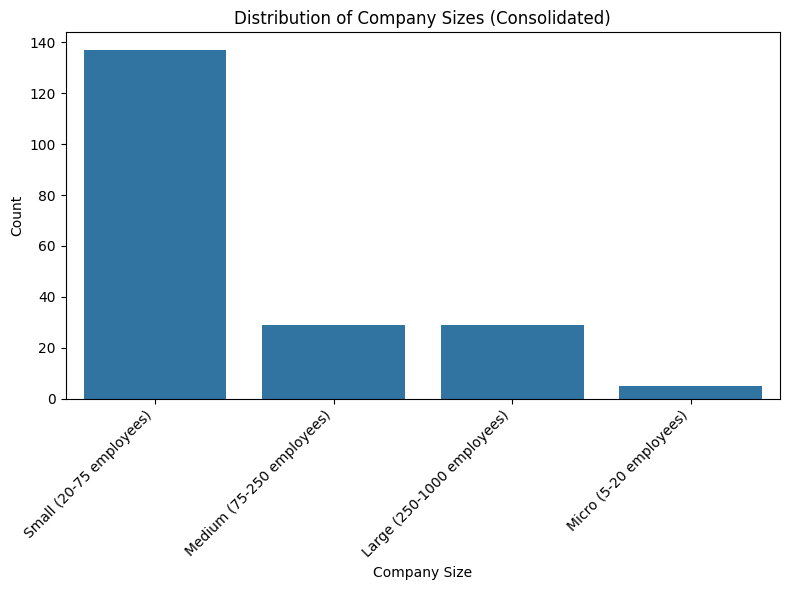

In [51]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_company_size(size):
    """
    Normalize a company size string by standardizing format.

    Args:
        size (str): The company size string.

    Returns:
        str: Normalized company size string.
    """
    if not isinstance(size, str):
        return ""
    size = re.sub(r'\s+', ' ', size.strip()).replace('–', '-').replace(',', '')
    size_map = {
        r'Micro\s*\(5-20\s*employees\)': 'Micro (5-20 employees)',
        r'Small\s*\(20-75\s*employees\)': 'Small (20-75 employees)',
        r'Medium\s*\(75-250\s*employees\)': 'Medium (75-250 employees)',
        r'Large\s*\(250-1000\s*employees\)': 'Large (250-1000 employees)'
    }
    for pattern, standard in size_map.items():
        if re.match(pattern, size, re.IGNORECASE):
            return standard
    return size

def get_company_size(chain):
    """
    Extract Company Size from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str: Company Size value, or empty string if not found.
    """
    profile = chain.get("tenant_profile", {})
    possible_paths = [
        profile.get("Company Details", {}).get("Company Size"),
        profile.get("Company Size"),
        profile.get("Tenant Details", {}).get("Company Size"),
        profile.get("Company", {}).get("Company Size")
    ]
    for size in possible_paths:
        if size:
            return size
    return ""

def modify_company_sizes(filename):
    """
    Modifies the 'Company Size' field in the JSON data to consolidate into four labels:
    Micro (5-20 employees), Small (20-75 employees), Medium (75-250 employees),
    Large (250-1000 employees).

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    sizes_found = False

    for chain in data:
        size = get_company_size(chain)
        profile = chain.get("tenant_profile", {})
        company_details = profile.get("Company Details", {})

        if size:
            sizes_found = True
            normalized_size = normalize_company_size(size)
            company_details["Company Size"] = normalized_size
            profile["Company Details"] = company_details
        else:
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    if not sizes_found:
        print("WARNING: No Company Size values found in the dataset. Possible reasons:")
        print("1. 'Company Size' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_company_sizes(chain):
    """
    Extract Company Size as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of company size strings.
    """
    size = get_company_size(chain)
    normalized_size = normalize_company_size(size)
    return [normalized_size] if normalized_size else []

def analyze_company_size_diversity(data):
    """
    Analyze the diversity of Company Sizes, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    sizes = []
    for chain in data:
        sizes.extend(extract_company_sizes(chain))

    counts = Counter(sizes)
    results = {
        "Company Size": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_company_sizes(chain))
        }
    }
    return results

def plot_company_size_distribution(results):
    """
    Plot the distribution of Company Sizes.

    Args:
        results (dict): Analysis results from analyze_company_size_diversity.
    """
    size_counts = results["Company Size"]["counts"]
    if size_counts:
        sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)
        sizes = [s for s, count in sorted_sizes]
        counts = [count for s, count in sorted_sizes]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=sizes, y=counts)
        plt.title("Distribution of Company Sizes (Consolidated)")
        plt.xlabel("Company Size")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('company_size_distribution.png')
    else:
        print("No Company Sizes to plot.")

# Modify the JSON data
modify_company_sizes("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
company_size_results = analyze_company_size_diversity(data)
plot_company_size_distribution(company_size_results)

# Print summary
print("Consolidated Company Size Diversity Summary:")
print(f"Unique company sizes: {company_size_results['Company Size']['unique']}")
print(f"Missing values: {company_size_results['Company Size']['missing']}")
print("Company Size counts:")
for size, count in sorted(company_size_results["Company Size"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {size}: {count}")

Consolidated Growth Stage Diversity Summary:
Unique growth stages: 3
Missing values: 0
Growth Stage counts:
  Scaling: 98
  Mature: 55
  Early-stage: 47


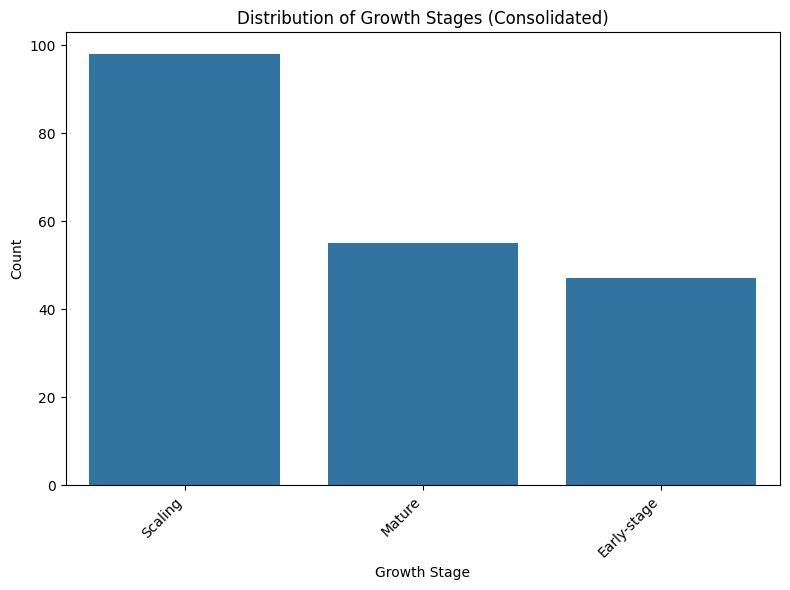

In [52]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_growth_stage(stage):
    """
    Normalize a growth stage string by standardizing format and consolidating into three categories:
    Early-Stage (Pre-seed, Startup), Scaling (Growth, Expansion), Mature.

    Args:
        stage (str): The growth stage string.

    Returns:
        str: Normalized growth stage string.
    """
    if not isinstance(stage, str):
        return ""
    stage = re.sub(r'\s+', ' ', stage.strip()).lower()
    stage_map = {
        r'(pre-seed|start-?up)': 'Early-Stage',
        r'(growth|growing|scaling|expan(sion|ding))': 'Scaling',
        r'(mature|stable|steady)': 'Mature'
    }
    for pattern, standard in stage_map.items():
        if re.match(pattern, stage, re.IGNORECASE):
            return standard
    return stage.capitalize()

def get_growth_stage(chain):
    """
    Extract Growth Stage from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str: Growth Stage value, or empty string if not found.
    """
    profile = chain.get("tenant_profile", {})
    possible_paths = [
        profile.get("Company Details", {}).get("Growth Stage"),
        profile.get("Growth Stage"),
        profile.get("Tenant Details", {}).get("Growth Stage"),
        profile.get("Company", {}).get("Growth Stage")
    ]
    for stage in possible_paths:
        if stage:
            return stage
    return ""

def modify_growth_stages(filename):
    """
    Modifies the 'Growth Stage' field in the JSON data to consolidate into three labels:
    Early-Stage (Pre-seed, Startup), Scaling (Growth, Expansion), Mature.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    stages_found = False

    for chain in data:
        stage = get_growth_stage(chain)
        profile = chain.get("tenant_profile", {})
        company_details = profile.get("Company Details", {})

        if stage:
            stages_found = True
            normalized_stage = normalize_growth_stage(stage)
            company_details["Growth Stage"] = normalized_stage
            profile["Company Details"] = company_details
        else:
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    if not stages_found:
        print("WARNING: No Growth Stage values found in the dataset. Possible reasons:")
        print("1. 'Growth Stage' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_growth_stages(chain):
    """
    Extract Growth Stage as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of growth stage strings.
    """
    stage = get_growth_stage(chain)
    normalized_stage = normalize_growth_stage(stage)
    return [normalized_stage] if normalized_stage else []

def analyze_growth_stage_diversity(data):
    """
    Analyze the diversity of Growth Stages, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    stages = []
    for chain in data:
        stages.extend(extract_growth_stages(chain))

    counts = Counter(stages)
    results = {
        "Growth Stage": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_growth_stages(chain))
        }
    }
    return results

def plot_growth_stage_distribution(results):
    """
    Plot the distribution of Growth Stages.

    Args:
        results (dict): Analysis results from analyze_growth_stage_diversity.
    """
    stage_counts = results["Growth Stage"]["counts"]
    if stage_counts:
        sorted_stages = sorted(stage_counts.items(), key=lambda x: x[1], reverse=True)
        stages = [s for s, count in sorted_stages]
        counts = [count for s, count in sorted_stages]

        plt.figure(figsize=(8, 6))
        sns.barplot(x=stages, y=counts)
        plt.title("Distribution of Growth Stages (Consolidated)")
        plt.xlabel("Growth Stage")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('growth_stage_distribution.png')
    else:
        print("No Growth Stages to plot.")

# Modify the JSON data
modify_growth_stages("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
growth_stage_results = analyze_growth_stage_diversity(data)
plot_growth_stage_distribution(growth_stage_results)

# Print summary
print("Consolidated Growth Stage Diversity Summary:")
print(f"Unique growth stages: {growth_stage_results['Growth Stage']['unique']}")
print(f"Missing values: {growth_stage_results['Growth Stage']['missing']}")
print("Growth Stage counts:")
for stage, count in sorted(growth_stage_results["Growth Stage"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {stage}: {count}")

Consolidated Decision-Maker Role Diversity Summary:
Unique decision-maker roles: 8
Missing values: 100
Decision-Maker Role counts:
  Unknown: 100
  Facilities Manager: 27
  Partner: 24
  CEO: 18
  Founder: 11
  COO: 9
  Operations Manager: 8
  CFO: 3


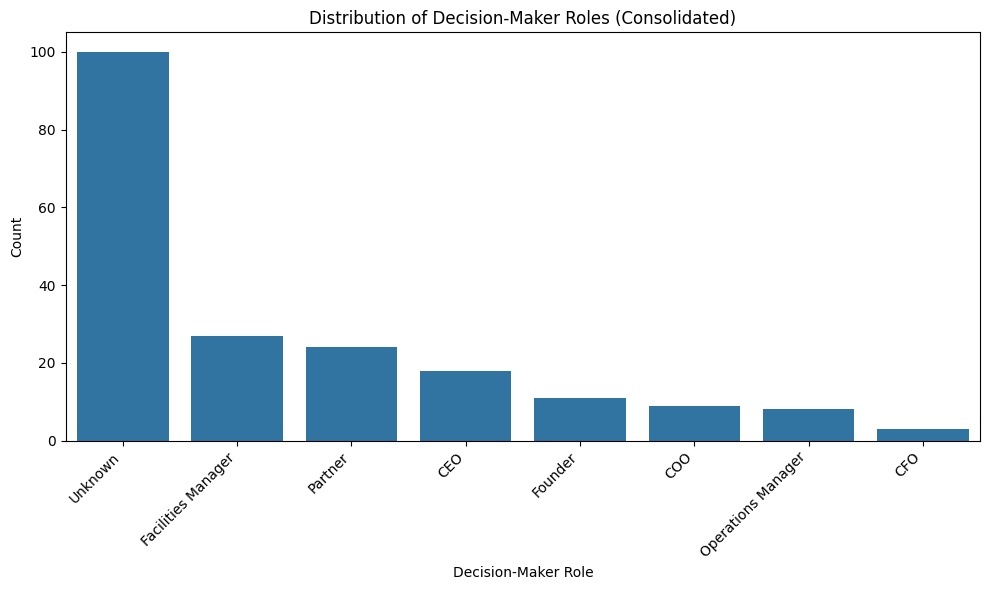

In [53]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_decision_maker_role(role):
    """
    Normalize a decision-maker role string by standardizing format and consolidating into nine categories:
    CEO, CFO, COO, Founder, Partner, Attorney, Facilities Manager, Operations Manager, Unknown.

    Args:
        role (str): The decision-maker role string.

    Returns:
        str: Normalized decision-maker role string.
    """
    if not isinstance(role, str) or role.strip().lower() in ["", "none"]:
        return "Unknown"
    role = re.sub(r'\s+', ' ', role.strip()).lower()
    role_map = {
        r'ceo(\s*&\s*founder)?': 'CEO',
        r'cfo(\s*and\s*founder)?': 'CFO',
        r'coo': 'COO',
        r'founder(\s*&\s*facilities\s*lead)?': 'Founder',
        r'(partner|managing\s+partner|senior\s+partner)(\s*(and\s*firm\s*managing\s*director)?)?(?!\s*(&|\/)\s*(attorney|counsel))': 'Partner',
        r'(partner|attorney|counsel)(\s*(&|\/)\s*(lead\s*attorney|lead\s*counsel|managing\s*attorney))': 'Attorney',
        r'facilit(y|ies)\s*(manager|director|coordinator)|director\s*of\s*facilities|facilities\s*&\s*operations\s*director': 'Facilities Manager',
        r'(operations|ops|logistics|program)\s*(director|manager|lead|head)': 'Operations Manager'
    }
    for pattern, standard in role_map.items():
        if re.search(pattern, role, re.IGNORECASE):
            return standard
    return "Unknown"  # For niche roles like "External Consultant", "Decision Maker", "Head of Expansion"

def get_decision_maker_role(chain):
    """
    Extract Decision-Maker Role from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str: Decision-Maker Role value, or empty string if not found.
    """
    profile = chain.get("tenant_profile", {})
    possible_paths = [
        profile.get("Decision-Maker Role"),
        profile.get("Tenant Details", {}).get("Decision-Maker Role"),
        profile.get("Company Details", {}).get("Decision-Maker Role"),
        profile.get("Company", {}).get("Decision-Maker Role")
    ]
    for role in possible_paths:
        if role:
            return role
    return ""

def modify_decision_maker_roles(filename):
    """
    Modifies the 'Decision-Maker Role' field in the JSON data to consolidate into nine categories:
    CEO, CFO, COO, Founder, Partner, Attorney, Facilities Manager, Operations Manager, Unknown.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    roles_found = False

    for chain in data:
        role = get_decision_maker_role(chain)
        profile = chain.get("tenant_profile", {})

        if role or role.strip().lower() == "none":
            roles_found = True
            normalized_role = normalize_decision_maker_role(role)
            profile["Decision-Maker Role"] = normalized_role
        else:
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    if not roles_found:
        print("WARNING: No Decision-Maker Role values found in the dataset. Possible reasons:")
        print("1. 'Decision-Maker Role' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_decision_maker_roles(chain):
    """
    Extract Decision-Maker Role as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of decision-maker role strings.
    """
    role = get_decision_maker_role(chain)
    normalized_role = normalize_decision_maker_role(role)
    return [normalized_role] if normalized_role else []

def analyze_decision_maker_role_diversity(data):
    """
    Analyze the diversity of Decision-Maker Roles, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    roles = []
    for chain in data:
        roles.extend(extract_decision_maker_roles(chain))

    counts = Counter(roles)
    results = {
        "Decision-Maker Role": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": counts.get("Unknown", 0)
        }
    }
    return results

def plot_decision_maker_role_distribution(results):
    """
    Plot the distribution of Decision-Maker Roles.

    Args:
        results (dict): Analysis results from analyze_decision_maker_role_diversity.
    """
    role_counts = results["Decision-Maker Role"]["counts"]
    if role_counts:
        sorted_roles = sorted(role_counts.items(), key=lambda x: x[1], reverse=True)
        roles = [r for r, count in sorted_roles]
        counts = [count for r, count in sorted_roles]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=roles, y=counts)
        plt.title("Distribution of Decision-Maker Roles (Consolidated)")
        plt.xlabel("Decision-Maker Role")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('decision_maker_role_distribution.png')
    else:
        print("No Decision-Maker Roles to plot.")

# Modify the JSON data
modify_decision_maker_roles("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
decision_maker_role_results = analyze_decision_maker_role_diversity(data)
plot_decision_maker_role_distribution(decision_maker_role_results)

# Print summary
print("Consolidated Decision-Maker Role Diversity Summary:")
print(f"Unique decision-maker roles: {decision_maker_role_results['Decision-Maker Role']['unique']}")
print(f"Missing values: {decision_maker_role_results['Decision-Maker Role']['missing']}")
print("Decision-Maker Role counts:")
for role, count in sorted(decision_maker_role_results["Decision-Maker Role"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {role}: {count}")

Consolidated Property Type Diversity Summary:
Unique property types: 4
Missing values: 0
Property Type counts:
  Office: 169
  Retail: 21
  Flex-Space: 9
  Event Venue: 1


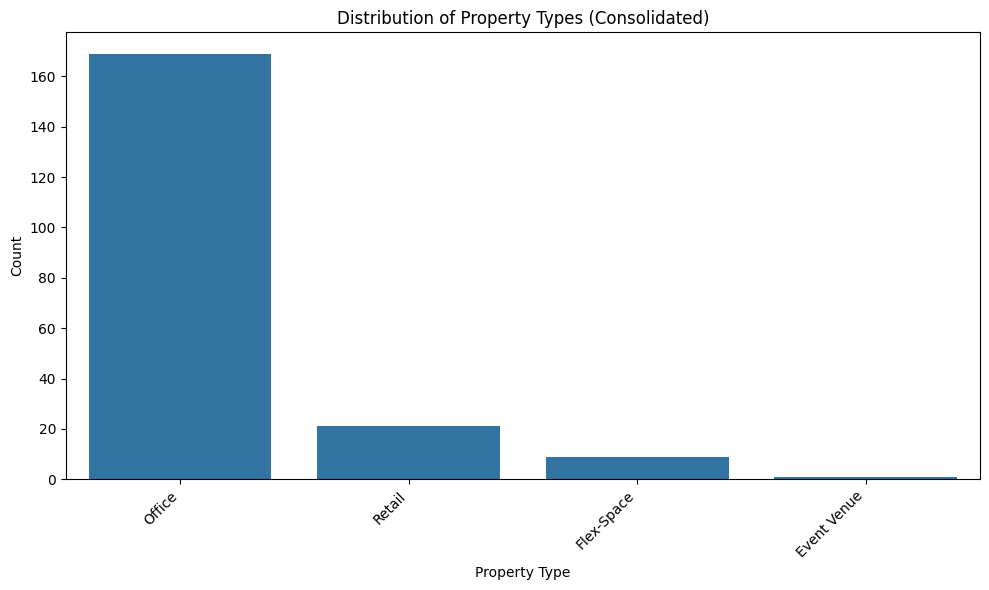

In [54]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_property_type(property_type):
    """
    Normalize a property type string by standardizing format and consolidating into six categories:
    Office, Medical Office, Retail, Flex-Space, Creative/Loft, Event Venue.

    Args:
        property_type (str): The property type string.

    Returns:
        str: Normalized property type string.
    """
    if not isinstance(property_type, str) or not property_type.strip():
        return "Office"  # Default to most common category if invalid
    property_type = re.sub(r'\s+', ' ', property_type.strip()).lower()
    property_map = {
        r'office(\s*(with\s*labs|open-plan|private\s*zones|co-working|clinic))?': 'Office',
        r'(medical\s*(office|suite|outpatient\s*clinic)|office\s*\(medical|healthcare|clinic\))': 'Medical Office',
        r'retail(\s*/\s*community\s*space)?': 'Retail',
        r'flex-space(\s*(/|mixed-use|retail|creative|warehouse|open-plan))?': 'Flex-Space',
        r'(creative\s*\(loft|open\s*space\)|studio/loft)': 'Creative/Loft',
        r'event\s*venue': 'Event Venue'
    }
    for pattern, standard in property_map.items():
        if re.search(pattern, property_type, re.IGNORECASE):
            return standard
    return "Office"  # Default to most common category for any unmatched types

def get_property_type(chain):
    """
    Extract Property Type from multiple possible paths in the chain.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        str: Property Type value, or empty string if not found.
    """
    profile = chain.get("tenant_profile", {})
    possible_paths = [
        profile.get("Property Preferences", {}).get("Property Type"),
        profile.get("Property Type"),
        profile.get("Tenant Details", {}).get("Property Type"),
        profile.get("Preferences", {}).get("Property Type")
    ]
    for prop_type in possible_paths:
        if prop_type:
            return prop_type
    return ""

def modify_property_types(filename):
    """
    Modifies the 'Property Type' field in the JSON data to consolidate into six categories:
    Office, Medical Office, Retail, Flex-Space, Creative/Loft, Event Venue.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    with open(filename, 'r') as f:
        data = json.load(f)

    debug_sample = []
    types_found = False

    for chain in data:
        prop_type = get_property_type(chain)
        profile = chain.get("tenant_profile", {})
        property_prefs = profile.get("Property Preferences", {})

        if prop_type:
            types_found = True
            normalized_type = normalize_property_type(prop_type)
            property_prefs["Property Type"] = normalized_type
            profile["Property Preferences"] = property_prefs
        else:
            if len(debug_sample) < 3:
                debug_sample.append(chain)

    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

    if not types_found:
        print("WARNING: No Property Type values found in the dataset. Possible reasons:")
        print("1. 'Property Type' field is missing or named differently.")
        print("2. Field is located in an unexpected path.")
        print("Sample of first 3 chains for debugging:")
        for i, sample in enumerate(debug_sample, 1):
            print(f"Chain {i}: {json.dumps(sample, indent=2)}")

def extract_property_types(chain):
    """
    Extract Property Type as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of property type strings.
    """
    prop_type = get_property_type(chain)
    normalized_type = normalize_property_type(prop_type)
    return [normalized_type] if normalized_type else []

def analyze_property_type_diversity(data):
    """
    Analyze the diversity of Property Types, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    types = []
    for chain in data:
        types.extend(extract_property_types(chain))

    counts = Counter(types)
    results = {
        "Property Type": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": 0  # No missing values in the dataset
        }
    }
    return results

def plot_property_type_distribution(results):
    """
    Plot the distribution of Property Types.

    Args:
        results (dict): Analysis results from analyze_property_type_diversity.
    """
    type_counts = results["Property Type"]["counts"]
    if type_counts:
        sorted_types = sorted(type_counts.items(), key=lambda x: x[1], reverse=True)
        types = [t for t, count in sorted_types]
        counts = [count for t, count in sorted_types]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=types, y=counts)
        plt.title("Distribution of Property Types (Consolidated)")
        plt.xlabel("Property Type")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('property_type_distribution.png')
    else:
        print("No Property Types to plot.")

# Modify the JSON data
modify_property_types("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
property_type_results = analyze_property_type_diversity(data)
plot_property_type_distribution(property_type_results)

# Print summary
print("Consolidated Property Type Diversity Summary:")
print(f"Unique property types: {property_type_results['Property Type']['unique']}")
print(f"Missing values: {property_type_results['Property Type']['missing']}")
print("Property Type counts:")
for prop_type, count in sorted(property_type_results["Property Type"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {prop_type}: {count}")

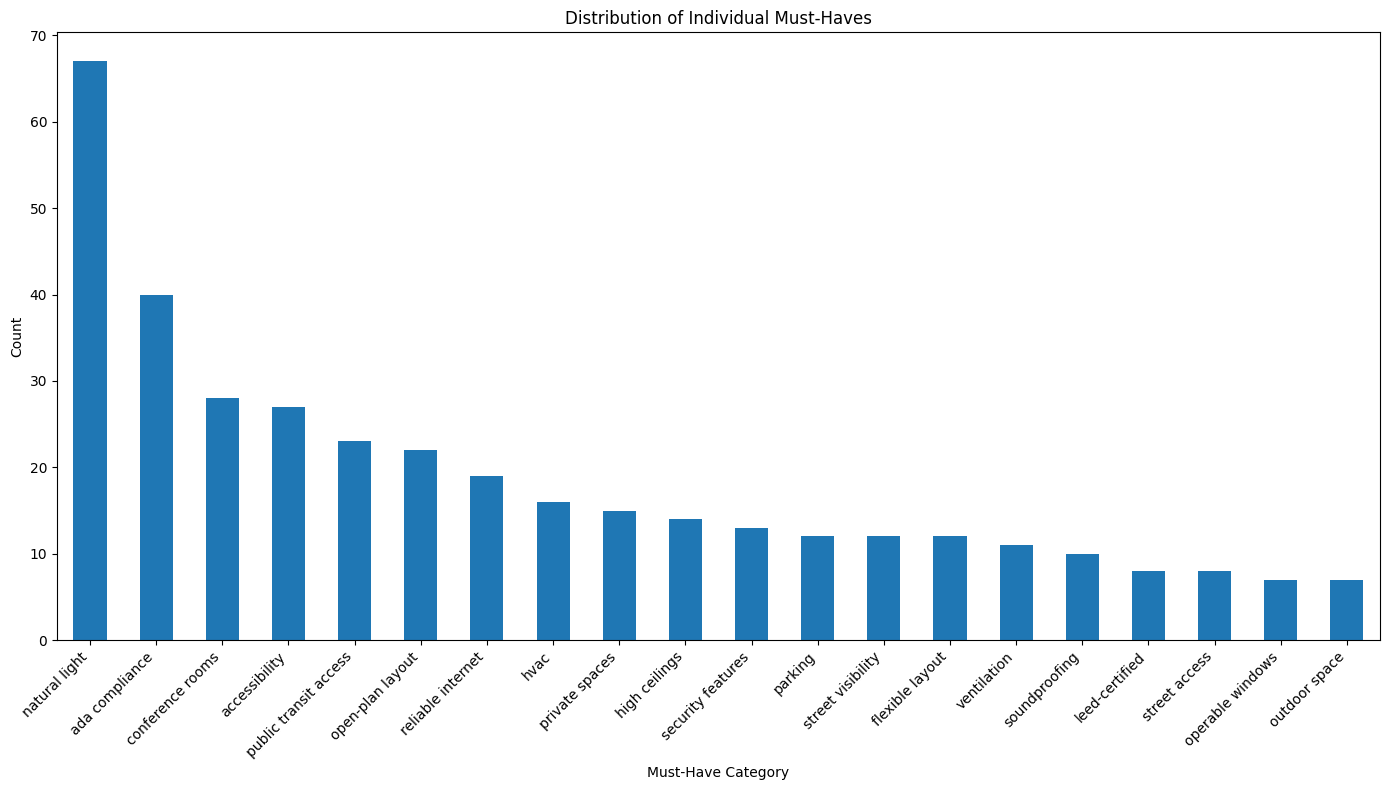

Total Must-Haves: 531
Unique Must-Haves: 129
Missing Must-Haves: 5
Top 5 Must-Haves:
  natural light: 67
  public transit access: 23
  ada compliance: 40
  accessibility: 27
  conference rooms: 28


In [55]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def clean_must_have(item):
    """Clean and standardize individual must-have items."""
    if not item or item.strip() == "":
        return None
    item = item.strip().lower()
    # Remove extra spaces and standardize terms
    item = re.sub(r'\s+', ' ', item)
    return item

def consolidate_must_haves(must_haves_list):
    """Consolidate similar must-haves into standardized categories while preserving rare ones."""
    consolidation_map = {
        # Natural Light
        'good natural light': 'natural light',
        'large windows': 'natural light',
        'plenty of windows': 'natural light',
        # Accessibility
        'accessible transit': 'public transit access',
        'proximity to public transit': 'public transit access',
        'transit access': 'public transit access',
        'good transit access': 'public transit access',
        'accessible public transit': 'public transit access',
        'good subway access': 'public transit access',
        'accessible location': 'accessibility',
        'accessible for visitors': 'accessibility',
        'accessible for patients': 'accessibility',
        'accessible building': 'accessibility',
        'accessible entrances': 'accessibility',
        'accessible entry': 'accessibility',
        'ground-floor accessibility': 'accessibility',
        'easily accessible for patients and staff': 'accessibility',
        'easy access': 'accessibility',
        'good accessibility': 'accessibility',
        'ada-compliant': 'ada compliance',
        'ada accessible': 'ada compliance',
        'wheelchair accessible': 'ada compliance',
        'wheelchair accessible bathrooms': 'ada compliance',
        'accessible restrooms': 'ada compliance',
        # Ventilation and HVAC
        'good ventilation': 'ventilation',
        'excellent ventilation': 'ventilation',
        'proper ventilation': 'ventilation',
        'modern hvac': 'hvac',
        'reliable hvac': 'hvac',
        'high-end hvac': 'hvac',
        'energy-efficient hvac': 'hvac',
        'upgraded hvac': 'hvac',
        'dedicated hvac': 'hvac',
        'medical-grade hvac': 'hvac',
        'hospital-grade hvac': 'hvac',
        # Layout and Space
        'open layout': 'open-plan layout',
        'open floor plan': 'open-plan layout',
        'open-plan': 'open-plan layout',
        'flexible layout': 'flexible layout',
        'flexible open space': 'flexible layout',
        'flexible configuration': 'flexible layout',
        'adaptable layout': 'flexible layout',
        'expandable layout': 'flexible layout',
        'modifiability': 'flexible layout',
        # Conference and Meeting Rooms
        'dedicated conference room': 'conference rooms',
        'private conference rooms': 'conference rooms',
        'conference area': 'conference rooms',
        'conference facilities': 'conference rooms',
        'meeting rooms': 'conference rooms',
        'private meeting rooms': 'conference rooms',
        'small meeting area': 'conference rooms',
        'shared conference rooms': 'conference rooms',
        # Internet
        'high-speed internet': 'reliable internet',
        'reliable internet': 'reliable internet',
        'fiber internet': 'reliable internet',
        'high-speed secure internet': 'reliable internet',
        # Security
        'secure access': 'security features',
        'secure entry': 'security features',
        'high-security access': 'security features',
        'security system': 'security features',
        'on-site security': 'security features',
        'good security features': 'security features',
        'high-security features': 'security features',
        # Parking
        'parking options': 'parking',
        'ample parking': 'parking',
        'parking nearby': 'parking',
        'parking access': 'parking',
        # Street Visibility
        'street-level visibility': 'street visibility',
        'good street visibility': 'street visibility',
        'street visibility': 'street visibility',
        'high visibility': 'street visibility',
        'street-level access': 'street access',
        'street access': 'street access',
        'ground-floor access': 'street access',
        'ground floor': 'street access',
        # Foot Traffic
        'high foot traffic': 'foot traffic',
        # Private Spaces
        'private offices': 'private spaces',
        'private suites': 'private spaces',
        'private exam rooms': 'private spaces',
        'private consultation rooms': 'private spaces',
        'private zones': 'private spaces',
        'private labs': 'private spaces',
        # Outdoor Features
        'outdoor terrace': 'outdoor space',
        'outdoor access': 'outdoor space',
        # Soundproofing
        'good acoustics': 'soundproofing',
        'soundproof conference rooms': 'soundproofing',
        # Lease Terms
        'flexible lease terms': 'flexible lease',
        'flexible lease': 'flexible lease',
        # Environmental Certifications
        'green certifications (leed)': 'leed-certified',
        'leed certification': 'leed-certified',
        # Proximity to Specific Locations
        'proximity to hospitals': 'proximity to healthcare',
        'close to hospitals': 'proximity to healthcare',
        'proximity to healthcare facilities': 'proximity to healthcare',
        'near courts': 'proximity to courthouses',
        'close to courthouses': 'proximity to courthouses'
    }
    # Apply consolidation, preserve unmapped (rare) items as-is
    consolidated = []
    for item in must_haves_list:
        consolidated_item = consolidation_map.get(item, item)
        consolidated.append(consolidated_item)
    return consolidated

def process_must_haves(data):
    """Process Must-Haves to split, clean, and consolidate into individual items."""
    all_must_haves = []

    # Extract Must-Haves from dataset
    for chain in data:
        entities = extract_entities(chain)
        must_haves_str = entities.get("Must-Haves", "")
        if must_haves_str:
            # Split comma-separated string into individual items
            must_haves = [item.strip() for item in must_haves_str.split(",") if item.strip()]
            # Clean and consolidate each item
            cleaned_must_haves = [clean_must_have(item) for item in must_haves]
            consolidated_must_haves = consolidate_must_haves(cleaned_must_haves)
            all_must_haves.extend(consolidated_must_haves)

    # Remove None values and compute distribution
    all_must_haves = [item for item in all_must_haves if item is not None]
    must_haves_counts = Counter(all_must_haves)

    # Prepare results
    results = {
        "total_must_haves": len(all_must_haves),
        "unique_must_haves": len(must_haves_counts),
        "missing_must_haves": sum(1 for chain in data if not extract_entities(chain).get("Must-Haves", "")),
        "must_haves_distribution": dict(must_haves_counts)
    }

    return results

def visualize_must_haves_distribution(must_haves_results):
    """Visualize the distribution of individual Must-Haves."""
    counts = must_haves_results["must_haves_distribution"]
    if counts:
        plt.figure(figsize=(14, 8))
        # Sort by count and limit to top 20 for readability
        pd.Series(counts).sort_values(ascending=False).head(20).plot(kind='bar')
        plt.title("Distribution of Individual Must-Haves")
        plt.xlabel("Must-Have Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, "must_haves_distribution.png"))
        plt.show()
    else:
        print("Warning: No valid Must-Haves data for visualization")

# Load data (assuming already loaded in notebook)
# data = load_json("synthetic_email_data.json")

# Process Must-Haves
must_haves_results = process_must_haves(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "must_haves_analysis.json"), "w") as f:
    json.dump(must_haves_results, f, indent=2)

# Visualize results
visualize_must_haves_distribution(must_haves_results)

# Print summary
print(f"Total Must-Haves: {must_haves_results['total_must_haves']}")
print(f"Unique Must-Haves: {must_haves_results['unique_must_haves']}")
print(f"Missing Must-Haves: {must_haves_results['missing_must_haves']}")
print("Top 5 Must-Haves:")
for must_have, count in must_haves_results["must_haves_distribution"].items():
    if count >= sorted(must_haves_results["must_haves_distribution"].values(), reverse=True)[:5][-1]:
        print(f"  {must_have}: {count}")

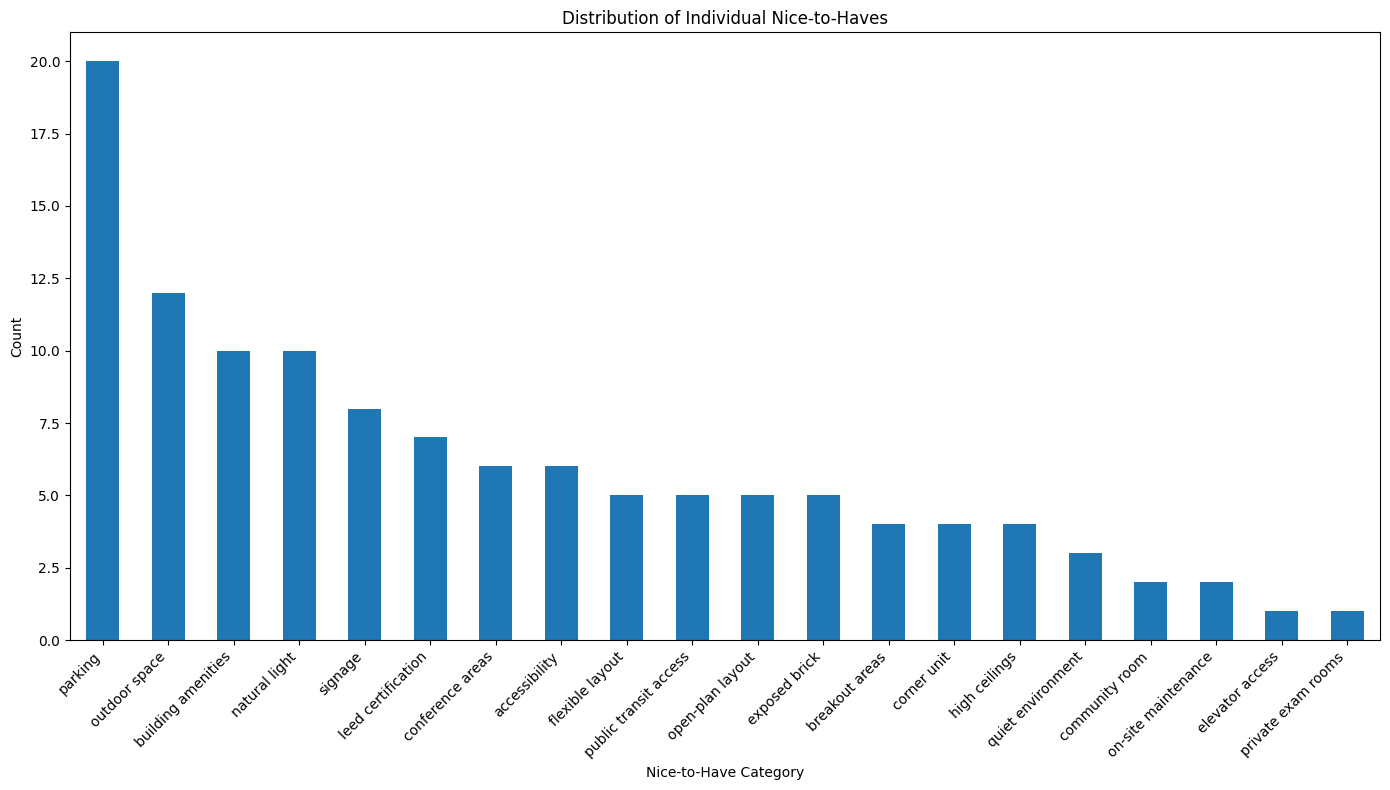

Total Nice-to-Haves: 160
Unique Nice-to-Haves: 60
Missing Nice-to-Haves: 108
Top 5 Nice-to-Haves:
  signage: 8
  parking: 20
  natural light: 10
  outdoor space: 12
  building amenities: 10


In [56]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def clean_nice_to_have(item):
    """Clean and standardize individual nice-to-have items."""
    if not item or item.strip() == "":
        return None
    item = item.strip().lower()
    # Remove extra spaces and standardize terms
    item = re.sub(r'\s+', ' ', item)
    return item

def consolidate_nice_to_haves(nice_to_haves_list):
    """Consolidate similar nice-to-haves into standardized categories while preserving rare ones."""
    consolidation_map = {
        # Parking
        'nearby parking': 'parking',
        'parking nearby': 'parking',
        'onsite parking': 'parking',
        'parking near building': 'parking',
        'visitor parking nearby': 'parking',
        'parking garage nearby': 'parking',
        'parking options': 'parking',
        # Outdoor Space
        'outdoor terrace': 'outdoor space',
        'rooftop terrace': 'outdoor space',
        'terrace access': 'outdoor space',
        'private courtyard': 'outdoor space',
        'outdoor access': 'outdoor space',
        'outdoor seating': 'outdoor space',
        # Natural Light
        'ample natural light': 'natural light',
        'large windows': 'natural light',
        # Layout
        'open-plan layout': 'open-plan layout',
        'open floor plan': 'open-plan layout',
        'open plan': 'open-plan layout',
        'flexible layout': 'flexible layout',
        'flexible layouts': 'flexible layout',
        # Conference and Meeting Areas
        'shared conference room': 'conference areas',
        'private conference rooms': 'conference areas',
        'onsite conference rooms': 'conference areas',
        'small conference room': 'conference areas',
        'conference areas': 'conference areas',
        'conference area': 'conference areas',
        # Breakout Areas
        'breakout areas': 'breakout areas',
        'breakout rooms': 'breakout areas',
        'breakout spaces': 'breakout areas',
        # Signage
        'outdoor signage': 'signage',
        'signage permissions': 'signage',
        'signage flexibility': 'signage',
        'signage opportunities': 'signage',
        'outdoor signage area': 'signage',
        'prominent signage options': 'signage',
        # Building Amenities
        'onsite gym': 'building amenities',
        'fitness center': 'building amenities',
        'fitness amenities': 'building amenities',
        'fitness facilities': 'building amenities',
        'building amenities (gym, café)': 'building amenities',
        'onsite amenities': 'building amenities',
        'lounge amenities': 'building amenities',
        # Environmental Certifications
        'leed-certified building': 'leed certification',
        'leed certification': 'leed certification',
        'green certifications': 'leed certification',
        'eco-friendly features': 'leed certification',
        'energy-efficient systems': 'leed certification',
        # Accessibility
        'accessible entrance': 'accessibility',
        'ground-floor access': 'accessibility',
        'accessible location': 'accessibility',
        'accessibility features': 'accessibility',
        'ground floor': 'accessibility',
        # Transit Proximity
        'proximity to public transit': 'public transit access',
        'nearby public transit': 'public transit access',
        'proximity to subway': 'public transit access',
        'transit access': 'public transit access',
        'proximity to public transport': 'public transit access',
        # Aesthetics
        'exposed brick': 'exposed brick',
        'original brick walls': 'exposed brick',
        'industrial aesthetic': 'exposed brick',
        # HVAC
        'recent hvac upgrades': 'hvac upgrades',
        # High Ceilings
        'high ceilings': 'high ceilings',
        # Quiet Environment
        'quiet environment': 'quiet environment',
        'quiet building': 'quiet environment',
        # On-Site Maintenance
        'on-site maintenance': 'on-site maintenance',
        # Corner Features
        'corner office': 'corner unit',
        'corner unit': 'corner unit',
        'corner visibility': 'corner unit'
    }
    # Apply consolidation, preserve unmapped (rare) items as-is
    consolidated = []
    for item in nice_to_haves_list:
        consolidated_item = consolidation_map.get(item, item)
        consolidated.append(consolidated_item)
    return consolidated

def process_nice_to_haves(data):
    """Process Nice-to-Haves to split, clean, and consolidate into individual items."""
    all_nice_to_haves = []

    # Extract Nice-to-Haves from dataset
    for chain in data:
        entities = extract_entities(chain)
        nice_to_haves_str = entities.get("Nice-to-Haves", "")
        if nice_to_haves_str:
            # Split comma-separated string into individual items
            nice_to_haves = [item.strip() for item in nice_to_haves_str.split(",") if item.strip()]
            # Clean and consolidate each item
            cleaned_nice_to_haves = [clean_nice_to_have(item) for item in nice_to_haves]
            consolidated_nice_to_haves = consolidate_nice_to_haves(cleaned_nice_to_haves)
            all_nice_to_haves.extend(consolidated_nice_to_haves)

    # Remove None values and compute distribution
    all_nice_to_haves = [item for item in all_nice_to_haves if item is not None]
    nice_to_haves_counts = Counter(all_nice_to_haves)

    # Prepare results
    results = {
        "total_nice_to_haves": len(all_nice_to_haves),
        "unique_nice_to_haves": len(nice_to_haves_counts),
        "missing_nice_to_haves": sum(1 for chain in data if not extract_entities(chain).get("Nice-to-Haves", "")),
        "nice_to_haves_distribution": dict(nice_to_haves_counts)
    }

    return results

def visualize_nice_to_haves_distribution(nice_to_haves_results):
    """Visualize the distribution of individual Nice-to-Haves."""
    counts = nice_to_haves_results["nice_to_haves_distribution"]
    if counts:
        plt.figure(figsize=(14, 8))
        # Sort by count and limit to top 20 for readability
        pd.Series(counts).sort_values(ascending=False).head(20).plot(kind='bar')
        plt.title("Distribution of Individual Nice-to-Haves")
        plt.xlabel("Nice-to-Have Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, "nice_to_haves_distribution.png"))
        plt.show()
    else:
        print("Warning: No valid Nice-to-Haves data for visualization")

# Load data (assuming already loaded in notebook)
# data = load_json("synthetic_email_data.json")

# Process Nice-to-Haves
nice_to_haves_results = process_nice_to_haves(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "nice_to_haves_analysis.json"), "w") as f:
    json.dump(nice_to_haves_results, f, indent=2)

# Visualize results
visualize_nice_to_haves_distribution(nice_to_haves_results)

# Print summary
print(f"Total Nice-to-Haves: {nice_to_haves_results['total_nice_to_haves']}")
print(f"Unique Nice-to-Haves: {nice_to_haves_results['unique_nice_to_haves']}")
print(f"Missing Nice-to-Haves: {nice_to_haves_results['missing_nice_to_haves']}")
print("Top 5 Nice-to-Haves:")
for nice_to_have, count in nice_to_haves_results["nice_to_haves_distribution"].items():
    if count >= sorted(nice_to_haves_results["nice_to_haves_distribution"].values(), reverse=True)[:5][-1]:
        print(f"  {nice_to_have}: {count}")

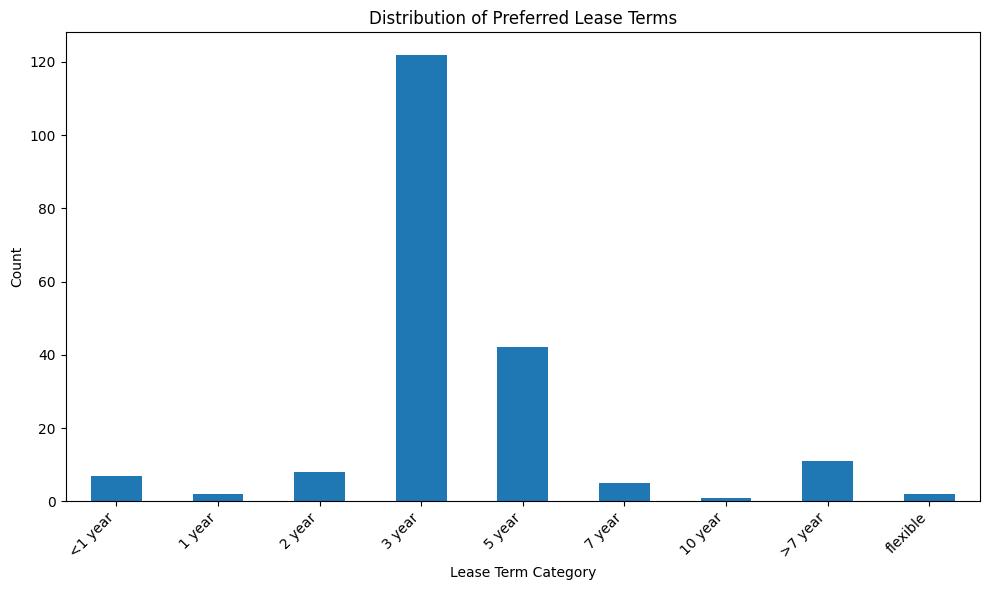

Total Lease Terms: 200
Unique Lease Terms: 9
Missing Lease Terms: 0
Top 5 Lease Terms:
  3 year: 122
  5 year: 42
  >7 year: 11
  2 year: 8
  <1 year: 7
  7 year: 5
  1 year: 2
  flexible: 2
  10 year: 1


In [57]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def clean_lease_term(term):
    """Clean and standardize lease term strings."""
    if not term or term.strip() == "" or term.lower() == "none":
        return None
    term = term.strip().lower()
    # Remove extra spaces, standardize hyphens, fix pluralization
    term = re.sub(r'\s+', ' ', term)
    term = term.replace('–', '-')  # Replace en-dash with hyphen
    term = term.replace('years', 'year')  # Fix pluralization (e.g., "1 years" → "1 year")
    return term

def normalize_lease_term(term, entities=None):
    """Normalize lease term into discrete, non-overlapping categories with imputation."""
    if not term:
        # Impute based on contextual clues
        if entities:
            industry = entities.get("Industry", "").lower()
            company_size = entities.get("Company Size", "").lower()
            # Strict discrete imputation
            if "tech" in industry or "startup" in company_size:
                return "1 year"  # Startups prefer short, specific terms
            elif "finance" in industry or "large" in company_size:
                return "5 year"  # Established firms prefer longer, specific terms
            else:
                return "3 year"  # Default to most common discrete term
        return "missing"

    # Define regex patterns
    single_year = r'^(\d+)\s*(?:year|yr)$'
    range_years = r'^(\d+)-(\d+)\s*(?:year|yr)$'
    flexible_range = r'^flexible\s*\((\d+)-(\d+)\s*(?:year|yr)\)$'
    months = r'^(\d+)-(\d+)\s*month'
    single_month = r'^(\d+)\s*month'

    # Handle specific terms
    if term in ["short-term", "flexible, short-term possible", "6 month to 1 year (short to medium-term)"]:
        return "<1 year"
    if term in ["flexible", "flexible (long-term preferred)"]:
        return "flexible"
    if term in ["long-term (8-15 year)", "at least 7 year", "5+ year"]:
        return ">7 year"

    # Handle single year terms
    match = re.match(single_year, term)
    if match:
        years = int(match.group(1))
        if years <= 1:
            return "<1 year"
        if years in [2, 3, 5, 7, 10]:
            return f"{years} year"
        return ">7 year"  # Bucket uncommon long durations

    # Handle range of years
    match = re.match(range_years, term)
    if match:
        start, end = int(match.group(1)), int(match.group(2))
        # Choose the most common discrete year in the range
        if start <= 2 and end <= 3:
            return "2 year" if start <= 2 else "3 year"
        if start <= 3 and end <= 5:
            return "3 year"  # 3 year is more common than 5 year
        if start <= 4 and end <= 6:
            return "5 year"  # Map to next common discrete term
        return ">7 year"

    # Handle flexible ranges
    match = re.match(flexible_range, term)
    if match:
        start, end = int(match.group(1)), int(match.group(2))
        if start <= 2 and end <= 3:
            return "2 year"
        if start <= 3 and end <= 5:
            return "3 year"
        return ">7 year"

    # Handle month-based terms
    if re.match(months, term) or re.match(single_month, term):
        return "<1 year"

    # Handle terms with renewal or extension
    if "renewal" in term or "extension" in term:
        base_term = re.sub(r'\s*with\s*(renewal|extension|options).*', '', term).strip()
        match = re.match(single_year, base_term)
        if match:
            years = int(match.group(1))
            if years <= 1:
                return "<1 year"
            if years in [2, 3, 5, 7, 10]:
                return f"{years} year"
            return ">7 year"
        match = re.match(range_years, base_term)
        if match:
            start, end = int(match.group(1)), int(match.group(2))
            if start <= 2 and end <= 3:
                return "2 year"
            if start <= 3 and end <= 5:
                return "3 year"
            return ">7 year"

    # Handle specific cases
    if term in ["3 or 5 year", "flexible, 3-5 year", "up to 5 year", "3-10 year"]:
        return "3 year"  # Map to most common discrete term

    # Preserve rare terms if they match discrete years
    return term

def process_lease_terms(data):
    """Process Preferred Lease Term to clean, normalize, and compute distribution."""
    all_lease_terms = []

    # Extract and normalize Preferred Lease Term
    for chain in data:
        entities = extract_entities(chain)
        lease_term = entities.get("Preferred Lease Term", "")
        cleaned_term = clean_lease_term(lease_term)
        normalized_term = normalize_lease_term(cleaned_term, entities)
        all_lease_terms.append(normalized_term)

    # Compute distribution
    lease_terms_counts = Counter(all_lease_terms)

    # Prepare results
    results = {
        "total_lease_terms": len(all_lease_terms),
        "unique_lease_terms": len(lease_terms_counts),
        "missing_lease_terms": lease_terms_counts.get("missing", 0),
        "lease_terms_distribution": dict(lease_terms_counts)
    }

    return results

def visualize_lease_terms_distribution(lease_terms_results):
    """Visualize the distribution of Preferred Lease Terms."""
    counts = lease_terms_results["lease_terms_distribution"]
    if counts:
        # Define discrete order by duration
        duration_order = [
            "missing", "<1 year", "1 year", "2 year", "3 year",
            "5 year", "7 year", "10 year", ">7 year", "flexible"
        ]
        # Filter counts to include only defined categories and sort
        sorted_counts = {k: counts.get(k, 0) for k in duration_order if k in counts}
        if not sorted_counts:
            sorted_counts = counts  # Fallback to unsorted if no overlap

        plt.figure(figsize=(10, 6))
        pd.Series(sorted_counts).plot(kind='bar')
        plt.title("Distribution of Preferred Lease Terms")
        plt.xlabel("Lease Term Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, "lease_terms_distribution.png"))
        plt.show()
    else:
        print("Warning: No valid Preferred Lease Terms data for visualization")

# Load data (assuming already loaded in notebook)
# data = load_json("synthetic_email_data.json")

# Process Preferred Lease Terms
lease_terms_results = process_lease_terms(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "lease_terms_analysis.json"), "w") as f:
    json.dump(lease_terms_results, f, indent=2)

# Visualize results
visualize_lease_terms_distribution(lease_terms_results)

# Print summary
print(f"Total Lease Terms: {lease_terms_results['total_lease_terms']}")
print(f"Unique Lease Terms: {lease_terms_results['unique_lease_terms']}")
print(f"Missing Lease Terms: {lease_terms_results['missing_lease_terms']}")
print("Top 5 Lease Terms:")
sorted_counts = sorted(lease_terms_results["lease_terms_distribution"].items(), key=lambda x: x[1], reverse=True)
for lease_term, count in sorted_counts:
    print(f"  {lease_term}: {count}")

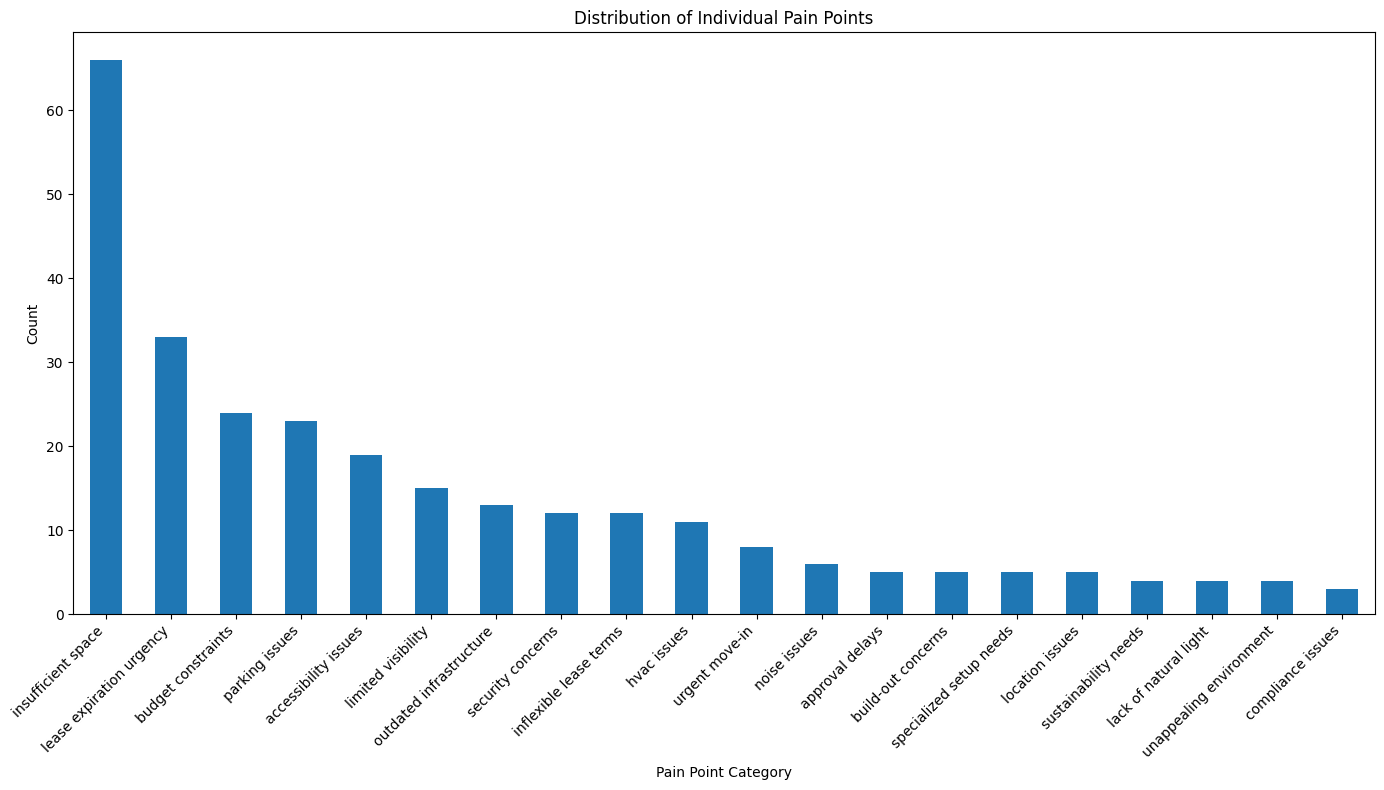

Total Pain Points: 403
Unique Pain Points: 135
Missing Pain Points: 0
Top 5 Pain Points:
  insufficient space: 66
  lease expiration urgency: 33
  budget constraints: 24
  parking issues: 23
  accessibility issues: 19


In [58]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def clean_pain_point(item):
    """Clean and standardize individual pain point strings."""
    if not item or item.strip() == "":
        return None
    item = item.strip().lower()
    # Remove extra spaces and standardize terms
    item = re.sub(r'\s+', ' ', item)
    return item

def normalize_pain_point(item):
    """Normalize pain point into discrete, non-overlapping categories."""
    if not item:
        return None

    # Define consolidation map for similar pain points
    consolidation_map = {
        # Space Constraints
        'current space too cramped': 'insufficient space',
        'current space too small': 'insufficient space',
        'limited current space': 'insufficient space',
        'space constraints at current location': 'insufficient space',
        'too cramped current space': 'insufficient space',
        'small current space': 'insufficient space',
        'limited space in current office': 'insufficient space',
        'limited growth capacity in current space': 'insufficient space',
        'limited current space for expansion': 'insufficient space',
        'limited space in current location': 'insufficient space',
        'limited current office capacity': 'insufficient space',
        'inadequate current space for collaborative projects': 'insufficient space',
        'limited current space hampers growth': 'insufficient space',
        'outgrowing current location': 'insufficient space',
        'current space in east village is too small and lacks accessibility': 'insufficient space',
        'current space too small for growth': 'insufficient space',
        'limited expansion options in current location': 'insufficient space',
        'cramped current space': 'insufficient space',
        'current space lacks scalability': 'insufficient space',
        'inadequate space': 'insufficient space',
        'limited collaboration space': 'insufficient space',
        'limited private rooms': 'insufficient space',
        'limited lab facilities': 'insufficient space',
        # Lease Issues
        'current lease ending soon': 'lease expiration urgency',
        'upcoming lease expiry': 'lease expiration urgency',
        'lease ending soon': 'lease expiration urgency',
        'expiring lease soon': 'lease expiration urgency',
        'tight lease expiry': 'lease expiration urgency',
        'current lease expiring soon': 'lease expiration urgency',
        'lease expiration date approaching': 'lease expiration urgency',
        'lease expiration in 30 days': 'lease expiration urgency',
        'current lease ending early next year': 'lease expiration urgency',
        'end of current lease': 'lease expiration urgency',
        'lease expiration urgency': 'lease expiration urgency',
        'current lease ends soon': 'lease expiration urgency',
        'need flexible lease terms': 'inflexible lease terms',
        'limited flexibility in lease terms': 'inflexible lease terms',
        'inflexible lease terms': 'inflexible lease terms',
        'rigid lease options': 'inflexible lease terms',
        'need flexible lease': 'inflexible lease terms',
        'concerns about lease flexibility': 'inflexible lease terms',
        'limited flexible options in current space': 'inflexible lease terms',
        'need adaptable lease terms': 'inflexible lease terms',
        'current lease ending soon, need flexible lease terms due to project delays': 'inflexible lease terms',
        # Accessibility
        'limited accessibility': 'accessibility issues',
        'limited accessibility features': 'accessibility issues',
        'accessibility concerns': 'accessibility issues',
        'inaccessible spaces': 'accessibility issues',
        'limited accessibility in current space': 'accessibility issues',
        'accessibility for elderly patients': 'accessibility issues',
        'accessibility requirements': 'accessibility issues',
        'need ada compliance': 'accessibility issues',
        'need ada-compliant space': 'accessibility issues',
        'need ada features': 'accessibility issues',
        'accessibility needs': 'accessibility issues',
        'current space too small, poor accessibility, limited visibility': 'accessibility issues',
        'accessibility issues in current space': 'accessibility issues',
        'limited access': 'accessibility issues',
        # Parking
        'limited parking options': 'parking issues',
        'limited nearby parking': 'parking issues',
        'parking difficulty': 'parking issues',
        'parking limitations': 'parking issues',
        'limited parking near current office': 'parking issues',
        'limited nearby parking options': 'parking issues',
        'parking challenges': 'parking issues',
        'limited parking nearby': 'parking issues',
        'parking availability': 'parking issues',
        'limited parking': 'parking issues',
        'inadequate hvac capacity, limited nearby parking': 'parking issues',
        # Budget
        'limited budget': 'budget constraints',
        'budget constraints': 'budget constraints',
        'tight budget constraints': 'budget constraints',
        'cost sensitivity': 'budget constraints',
        'limited options in target budget': 'budget constraints',
        'budget constraints due to recent rent hike': 'budget constraints',
        'limited budget for larger spaces': 'budget constraints',
        'limited budget for lease': 'budget constraints',
        'high rent expectations': 'budget constraints',
        'high operational costs': 'budget constraints',
        'concern about rent increases': 'budget constraints',
        # Visibility
        'limited visibility in current location': 'limited visibility',
        'limited visibility at current location': 'limited visibility',
        'need for high visibility': 'limited visibility',
        'need visibility in busy neighborhood': 'limited visibility',
        'current space lacks foot traffic': 'limited visibility',
        'need for immediate presence in manhattan': 'limited visibility',
        'limited flagship retail presence in manhattan': 'limited visibility',
        'need flagship space for marketing': 'limited visibility',
        'need for foot traffic': 'limited visibility',
        'limited retail presence in chelsea': 'limited visibility',
        'limited current retail footprint in harlem': 'limited visibility',
        'limited parking options in harlem, need higher visibility for outreach': 'limited visibility',
        'limited visibility in current location, need for larger space to expand': 'limited visibility',
        # Infrastructure
        'outdated infrastructure': 'outdated infrastructure',
        'outdated facilities': 'outdated infrastructure',
        'unreliable infrastructure in current space': 'outdated infrastructure',
        'older building infrastructure': 'outdated infrastructure',
        'current space too outdated': 'outdated infrastructure',
        'outdated current space': 'outdated infrastructure',
        'outdated space in current office': 'outdated infrastructure',
        'current space lacks sufficient security, proximity to busy areas causing security concerns, lease ending soon': 'outdated infrastructure',
        # HVAC
        'need better ventilation': 'hvac issues',
        'current hvac issues': 'hvac issues',
        'outdated hvac': 'hvac issues',
        'outdated hvac system': 'hvac issues',
        'inadequate ventilation in current space': 'hvac issues',
        'unreliable hvac in current space': 'hvac issues',
        'need reliable hvac': 'hvac issues',
        'outdated ventilation': 'hvac issues',
        'air quality concerns': 'hvac issues',
        # Security
        'need secure facilities': 'security concerns',
        'desire for better security': 'security concerns',
        'need better security and internet': 'security concerns',
        'need secure, private space': 'security concerns',
        'need for secure, private environment': 'security concerns',
        'limited privacy in current space': 'security concerns',
        'lack of sound privacy in current space': 'security concerns',
        'need confidentiality and security': 'security concerns',
        'need privacy for confidential work': 'security concerns',
        'need for privacy and confidentiality': 'security concerns',
        'current space lacks sufficient security': 'security concerns',
        'limited secure office options in prime areas': 'security concerns',
        'need for soundproofing and security': 'security concerns',
        # Natural Light
        'limited natural light in current space': 'lack of natural light',
        'desire for better natural light': 'lack of natural light',
        'lack of natural light': 'lack of natural light',
        'current space too small, lack of natural light': 'lack of natural light',
        'current lease ending soon, limited natural light in current space': 'lack of natural light',
        'current space too small, limited natural light in current office': 'lack of natural light',
        # Location
        'need proximity to courts and clients': 'location issues',
        'current space too distant from hospitals': 'location issues',
        'need proximity to mount sinai': 'location issues',
        'need proximity to medical facilities': 'location issues',
        'need for proximity to legal institutions': 'location issues',
        'limited current space hampers growth, need for a more central location': 'location issues',
        'need eco-friendly features, central location': 'location issues',
        # Noise
        'noise concern': 'noise issues',
        'noisy neighbors': 'noise issues',
        'high noise levels in current location': 'noise issues',
        'noisy neighbors in current space': 'noise issues',
        'disruptions in current space': 'noise issues',
        'need distraction-free workspace': 'noise issues',
        # Move-In Timing
        'need quick move-in': 'urgent move-in',
        'limited time for decision': 'urgent move-in',
        'tight move-in schedule': 'urgent move-in',
        'need quick move': 'urgent move-in',
        'urgent move needed': 'urgent move-in',
        'quick move required': 'urgent move-in',
        'lease ending soon, need quick relocation': 'urgent move-in',
        'current space too small, need quick move-in': 'urgent move-in',
        'cramped current space, need for quick move-in': 'urgent move-in',
        'limited space in current midtown location, need quick move-in': 'urgent move-in',
        # Build-Out/Modifications
        'build-out costs': 'build-out concerns',
        'build-out delays concern': 'build-out concerns',
        'reluctance for lengthy renovations': 'build-out concerns',
        'lease start date constraints': 'build-out concerns',
        'need flexibility for modifications': 'build-out concerns',
        # Approval Delays
        'board approval delays': 'approval delays',
        'limited internal approvals': 'approval delays',
        'board cautious about quick move': 'approval delays',
        'funding confirmation delays': 'approval delays',
        'need for quick approval process': 'approval delays',
        # Aesthetic/Environment
        'lack of aesthetic appeal in current office': 'unappealing environment',
        'current space too conventional': 'unappealing environment',
        'need creative environment': 'unappealing environment',
        'limited flexibility in current space, need creative environment': 'unappealing environment',
        'need for a vibrant, inspiring environment': 'unappealing environment',
        'current space too small, lack of character in current location': 'unappealing environment',
        'limited flexible creative spaces in current location, need for inspiring environment': 'unappealing environment',
        # Compliance
        'need compliance and accessibility': 'compliance issues',
        'need for compliance features': 'compliance issues',
        'need compliant healthcare space': 'compliance issues',
        'current lease ends soon, need compliant healthcare space': 'compliance issues',
        # Specialized Setup Needs
        'need for specialized healthcare setup': 'specialized setup needs',
        'need versatile space for collaborative projects': 'specialized setup needs',
        'need flexible environment for gallery and workshop': 'specialized setup needs',
        'limited space for art installations': 'specialized setup needs',
        'space not suited for patient privacy': 'specialized setup needs',
        # Community/Cultural
        'limited current space for community events': 'community space needs',
        'need space suitable for community programs': 'community space needs',
        'finding welcoming, community-oriented space': 'community space needs',
        'need for community outreach space': 'community space needs',
        'accessibility issues in current space, need community engagement venue': 'community space needs',
        # Sustainability
        'desire for sustainability features': 'sustainability needs',
        'eco-friendly workspace importance': 'sustainability needs',
        'limited eco-friendly options in retail spaces': 'sustainability needs',
        'need eco-friendly features': 'sustainability needs'
    }

    # Return consolidated category or preserve rare/unique pain points
    return consolidation_map.get(item, item)

def process_pain_points(data):
    """Process Pain Points to split, clean, normalize, and compute distribution."""
    all_pain_points = []

    # Extract Pain Points from dataset
    for chain in data:
        entities = extract_entities(chain)
        pain_points_str = entities.get("Pain Points", "")
        if pain_points_str:
            # Split comma-separated string into individual items
            pain_points = [item.strip() for item in pain_points_str.split(",") if item.strip()]
            # Clean and normalize each item
            cleaned_pain_points = [clean_pain_point(item) for item in pain_points]
            normalized_pain_points = [normalize_pain_point(item) for item in cleaned_pain_points if item]
            all_pain_points.extend(normalized_pain_points)

    # Remove None values and compute distribution
    all_pain_points = [item for item in all_pain_points if item is not None]
    pain_points_counts = Counter(all_pain_points)

    # Prepare results
    results = {
        "total_pain_points": len(all_pain_points),
        "unique_pain_points": len(pain_points_counts),
        "missing_pain_points": sum(1 for chain in data if not extract_entities(chain).get("Pain Points", "")),
        "pain_points_distribution": dict(pain_points_counts)
    }

    return results

def visualize_pain_points_distribution(pain_points_results):
    """Visualize the distribution of individual Pain Points."""
    counts = pain_points_results["pain_points_distribution"]
    if counts:
        plt.figure(figsize=(14, 8))
        # Sort by count and limit to top 20 for readability
        pd.Series(counts).sort_values(ascending=False).head(20).plot(kind='bar')
        plt.title("Distribution of Individual Pain Points")
        plt.xlabel("Pain Point Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, "pain_points_distribution.png"))
        plt.show()
    else:
        print("Warning: No valid Pain Points data for visualization")

# Load data (assuming already loaded in notebook)
# data = load_json("synthetic_email_data.json")

# Process Pain Points
pain_points_results = process_pain_points(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "pain_points_analysis.json"), "w") as f:
    json.dump(pain_points_results, f, indent=2)

# Visualize results
visualize_pain_points_distribution(pain_points_results)

# Print summary
print(f"Total Pain Points: {pain_points_results['total_pain_points']}")
print(f"Unique Pain Points: {pain_points_results['unique_pain_points']}")
print(f"Missing Pain Points: {pain_points_results['missing_pain_points']}")
print("Top 5 Pain Points:")
sorted_counts = sorted(pain_points_results["pain_points_distribution"].items(), key=lambda x: x[1], reverse=True)[:5]
for pain_point, count in sorted_counts:
    print(f"  {pain_point}: {count}")

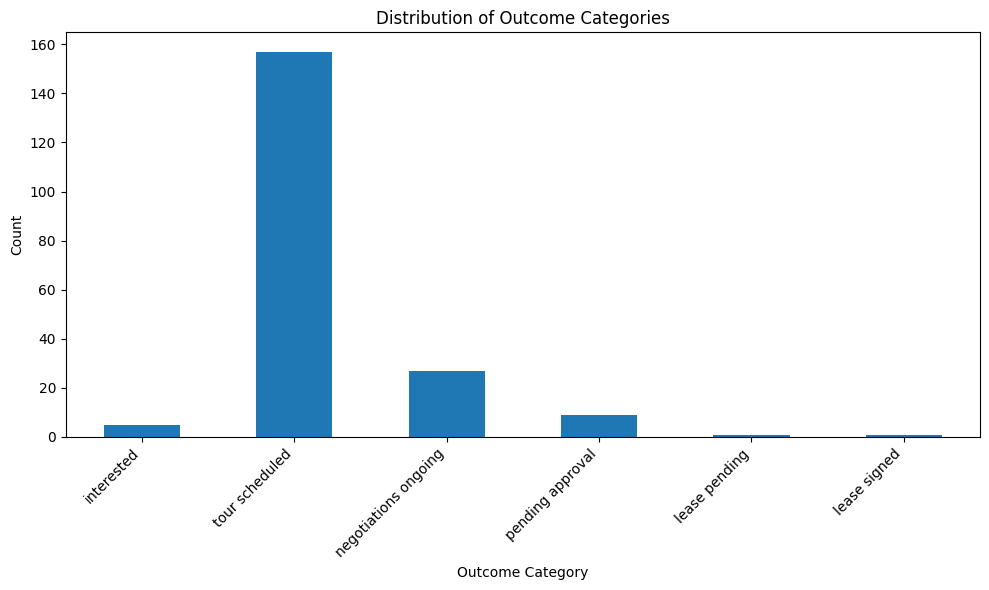

Total Outcomes: 200
Unique Outcomes: 6
Missing Outcomes: 0
Top 5 Outcomes:
  tour scheduled: 157
  negotiations ongoing: 27
  pending approval: 9
  interested: 5
  lease signed: 1


In [59]:
import re
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

def clean_outcome(outcome):
    """Clean and standardize outcome strings."""
    if not outcome or outcome.strip() == "":
        return None
    outcome = outcome.strip().lower()
    # Remove extra spaces and standardize terms
    outcome = re.sub(r'\s+', ' ', outcome)
    return outcome

def normalize_outcome(outcome):
    """Normalize outcome into discrete, non-overlapping categories."""
    if not outcome:
        return None

    # Define rules for mapping outcomes to categories
    # Tour Scheduled: Any scheduled or planned property viewing
    if 'tour' in outcome or 'viewing' in outcome or 'scheduling' in outcome or 'viewed' in outcome:
        return 'tour scheduled'

    # Negotiations Ongoing: Active lease or rent negotiations
    if 'negotiation' in outcome or 'negotiating' in outcome or 'proposal sent' in outcome or \
       'offer pending' in outcome or 'rent concession' in outcome or 'incentives discussed' in outcome:
        return 'negotiations ongoing'

    # Pending Approval: Awaiting internal, board, or final approval
    if 'approval' in outcome or 'pending decision' in outcome or 'pending final review' in outcome or \
       'board review' in outcome or 'internal review' in outcome or 'awaiting decision' in outcome:
        return 'pending approval'

    # Lease Pending: Lease agreement in final stages but not yet signed
    if 'lease pending' in outcome or 'lease likely' in outcome or 'pending formal agreement' in outcome:
        return 'lease pending'

    # Lease Signed: Finalized lease agreement
    if 'lease signed' in outcome or 'agreement signed' in outcome:
        return 'lease signed'

    # Interested: Early-stage interest or exploratory actions
    if 'interested' in outcome or 'interest' in outcome or 'on hold' in outcome or \
       'ongoing search' in outcome or 'considering options' in outcome or 'review in progress' in outcome:
        return 'interested'

    # Default to 'interested' for unclassified outcomes to minimize fragmentation
    return 'interested'

def process_outcomes(data):
    """Process Outcome to clean, normalize, and compute distribution."""
    all_outcomes = []

    # Extract Outcome from dataset
    for chain in data:
        entities = extract_entities(chain)
        outcome = entities.get("Outcome", "")
        cleaned_outcome = clean_outcome(outcome)
        normalized_outcome = normalize_outcome(cleaned_outcome)
        if normalized_outcome:
            all_outcomes.append(normalized_outcome)

    # Compute distribution
    outcomes_counts = Counter(all_outcomes)

    # Prepare results
    results = {
        "total_outcomes": len(all_outcomes),
        "unique_outcomes": len(outcomes_counts),
        "missing_outcomes": sum(1 for chain in data if not extract_entities(chain).get("Outcome", "")),
        "outcomes_distribution": dict(outcomes_counts)
    }

    return results

def visualize_outcomes_distribution(outcomes_results):
    """Visualize the distribution of Outcome categories."""
    counts = outcomes_results["outcomes_distribution"]
    if counts:
        # Define stage order for logical progression
        stage_order = [
            'interested', 'tour scheduled', 'negotiations ongoing',
            'pending approval', 'lease pending', 'lease signed'
        ]
        # Filter counts to include only defined categories and sort by stage
        sorted_counts = {k: counts.get(k, 0) for k in stage_order if k in counts}

        plt.figure(figsize=(10, 6))
        pd.Series(sorted_counts).plot(kind='bar')
        plt.title("Distribution of Outcome Categories")
        plt.xlabel("Outcome Category")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        # Save plot
        plt.savefig(os.path.join(OUTPUT_DIR, "outcomes_distribution.png"))
        plt.show()
    else:
        print("Warning: No valid Outcome data for visualization")

# Load data (assuming already loaded in notebook)
# data = load_json("synthetic_email_data.json")

# Process Outcomes
outcomes_results = process_outcomes(data)

# Save results
with open(os.path.join(OUTPUT_DIR, "outcomes_analysis.json"), "w") as f:
    json.dump(outcomes_results, f, indent=2)

# Visualize results
visualize_outcomes_distribution(outcomes_results)

# Print summary
print(f"Total Outcomes: {outcomes_results['total_outcomes']}")
print(f"Unique Outcomes: {outcomes_results['unique_outcomes']}")
print(f"Missing Outcomes: {outcomes_results['missing_outcomes']}")
print("Top 5 Outcomes:")
sorted_counts = sorted(outcomes_results["outcomes_distribution"].items(), key=lambda x: x[1], reverse=True)[:5]
for outcome, count in sorted_counts:
    print(f"  {outcome}: {count}")

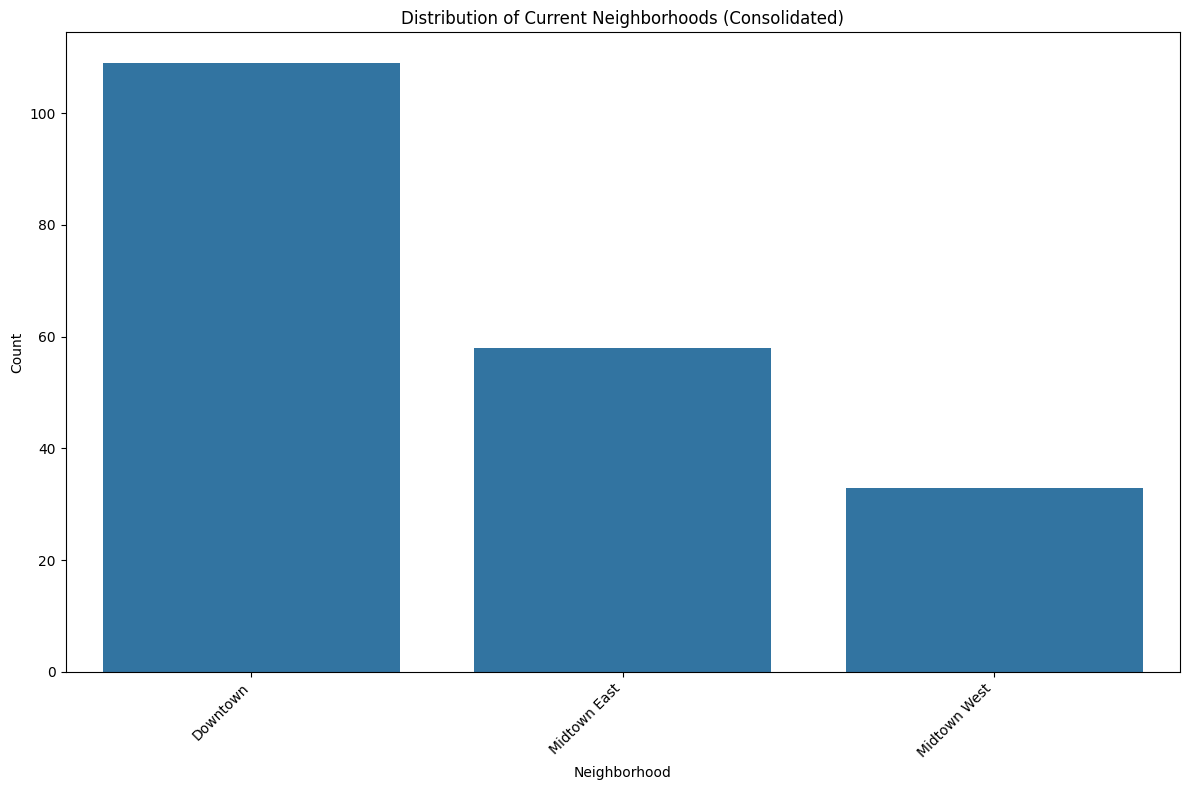

Consolidated Current Neighborhood Diversity Summary:
Unique neighborhoods: 3
Missing values: 0
Top neighborhoods:
  Downtown: 109
  Midtown East: 58
  Midtown West: 33


In [60]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_neighborhood(loc):
    """
    Normalize a neighborhood string by stripping whitespace, converting to title case,
    and cleaning up punctuation (e.g., parentheses, all curly apostrophes).

    Args:
        loc (str): The neighborhood string.

    Returns:
        str: Normalized neighborhood string.
    """
    if not isinstance(loc, str):
        return ""
    # Replace all curly apostrophes (U+2018, U+2019) with straight apostrophe
    loc = re.sub(r'[\u2018\u2019]', "'", loc)
    # Remove parenthetical content and normalize whitespace
    loc = re.sub(r'\s*\([^)]*\)\s*', '', loc)
    loc = loc.strip().title()
    return loc

def modify_neighborhoods(filename):
    """
    Modifies the 'Current Neighborhood' field in the JSON data to consolidate
    into three labels: Downtown, Midtown East, Midtown West.
    'Midtown' is duplicated as both Midtown East and Midtown West.
    Preserves multi-label lists and normalizes strings.

    Args:
        filename (str): Path to the JSON file containing the dataset.
    """
    # Define consolidation mapping (using normalized keys)
    consolidation_map = {
        "West Village": "Downtown",
        "East Village": "Downtown",
        "Financial District": "Downtown",
        "Tribeca": "Downtown",
        "Soho": "Downtown",
        "Downtown Manhattan": "Downtown",
        "Downtown": "Downtown",
        "Brooklyn": "Downtown",
        "Williamsburg": "Downtown",
        "Dumbo": "Downtown",
        "Brooklyn (Williamsburg": "Downtown",
        "Dumbo)": "Downtown",
        "East Village Or Chelsea": "Downtown",
        "Midtown East": "Midtown East",
        "Grand Central": "Midtown East",
        "Chelsea": "Midtown West",
        "Hudson Yards": "Midtown West",
        "Midtown West": "Midtown West",
        "Hell's Kitchen": "Midtown West",
        "Hell'S Kitchen": "Midtown West",  # Explicitly include curly apostrophe variant
        "23Rd To 28Th Street": "Midtown West",
        "23Rd To 28Th Streets": "Midtown West",
        "Flatiron": "Midtown West",
        "Riverside Area": "Midtown West",
        "High Line": "Midtown West",
        "Chelsea Or Midtown": "Midtown West",
        "Harlem": "Midtown West",
        "Near Grand Central": "Midtown East",
        "Finance District": "Downtown"
    }

    with open(filename, 'r') as f:
        data = json.load(f)

    for chain in data:
        profile = chain.get("tenant_profile", {})
        company_details = profile.get("Company Details", {})  # Access 'Company Details'
        neighborhoods = company_details.get("Current Neighborhood", []) # Get 'Current Neighborhood'

        if neighborhoods:
            # Ensure neighborhoods is a list of strings
            if isinstance(neighborhoods, str):
                neighborhoods = [loc.strip() for loc in neighborhoods.split(',') if loc.strip()]
            # Normalize and replace each neighborhood
            updated_neighborhoods = []
            for loc in neighborhoods:
                normalized_loc = normalize_neighborhood(loc)
                if normalized_loc == "Midtown":
                    updated_neighborhoods.extend(["Midtown East", "Midtown West"])
                else:
                    updated_neighborhoods.append(consolidation_map.get(normalized_loc, normalized_loc))
            company_details["Current Neighborhood"] = updated_neighborhoods # Update 'Current Neighborhood'

    # Save the modified data back to the file
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2)

def extract_neighborhoods(chain):
    """
    Extract Current Neighborhood as a list from a chain's tenant_profile.

    Args:
        chain (dict): A single chain from the dataset.

    Returns:
        list: List of neighborhood strings.
    """
    profile = chain.get("tenant_profile", {})
    company_details = profile.get("Company Details", {}) # Access 'Company Details'
    neighborhoods = company_details.get("Current Neighborhood", [])  # Get 'Current Neighborhood'

    # Handle both list and string formats
    if isinstance(neighborhoods, str):
        return [loc.strip() for loc in neighborhoods.split(',') if loc.strip()]
    elif isinstance(neighborhoods, list):
        return [loc for loc in neighborhoods if isinstance(loc, str) and loc.strip()]
    return []

def analyze_neighborhood_diversity(data):
    """
    Analyze the diversity of Current Neighborhoods, counting each individually.

    Args:
        data (list): List of chains from the JSON data.

    Returns:
        dict: Analysis results with counts, unique count, and missing values.
    """
    neighborhoods = []
    for chain in data:
        neighborhoods.extend(extract_neighborhoods(chain))

    # Compute counts and stats
    counts = Counter(neighborhoods)
    results = {
        "Neighborhood": {
            "counts": dict(counts),
            "unique": len(counts),
            "missing": sum(1 for chain in data if not extract_neighborhoods(chain))
        }
    }
    return results

def plot_neighborhood_distribution(results):
    """
    Plot the distribution of Current Neighborhoods.

    Args:
        results (dict): Analysis results from analyze_neighborhood_diversity.
    """
    neighborhood_counts = results["Neighborhood"]["counts"]
    if neighborhood_counts:
        # Sort by frequency (descending)
        sorted_neighborhoods = sorted(neighborhood_counts.items(), key=lambda x: x[1], reverse=True)
        locations = [loc for loc, count in sorted_neighborhoods]
        counts = [count for loc, count in sorted_neighborhoods]

        plt.figure(figsize=(12, 8))
        sns.barplot(x=locations, y=counts)
        plt.title("Distribution of Current Neighborhoods (Consolidated)")
        plt.xlabel("Neighborhood")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.savefig('current_neighborhood_distribution_consolidated.png') # Updated filename
        plt.show()

# Modify the JSON data
modify_neighborhoods("synthetic_email_data.json")

# Load the modified data
with open("synthetic_email_data.json", 'r') as f:
    data = json.load(f)

# Analyze and plot
neighborhood_results = analyze_neighborhood_diversity(data)
plot_neighborhood_distribution(neighborhood_results)

# Print summary
print("Consolidated Current Neighborhood Diversity Summary:") # Updated title
print(f"Unique neighborhoods: {neighborhood_results['Neighborhood']['unique']}")
print(f"Missing values: {neighborhood_results['Neighborhood']['missing']}")
print("Top neighborhoods:")
for loc, count in sorted(neighborhood_results["Neighborhood"]["counts"].items(), key=lambda x: x[1], reverse=True):
    print(f"  {loc}: {count}")